<a href="https://colab.research.google.com/github/MariiaKalinina/BM/blob/main/BM_v3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
from math import *
from scipy.special import lambertw
import matplotlib.pyplot as plt

In [2]:
!pip install GitPython

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 4.3 MB/s eta 0:00:00


In [3]:
from git import Repo
!git clone https://github.com/MariiaKalinina/BM.git

Cloning into 'BM'...
remote: Enumerating objects: 310, done.
remote: Counting objects: 100% (187/187), done.
remote: Compressing objects: 100% (116/116), done.
remote: Total 310 (delta 110), reused 128 (delta 71), pack-reused 123
Receiving objects: 100% (310/310), 18.60 MiB | 8.95 MiB/s, done.
Resolving deltas: 100% (186/186), done.


### Step 0. Data preparation

In [149]:
# import pandas as pd

df_constast = pd.read_csv('/content/BM/Constants.csv', delimiter=';', header=0)
df_well = pd.read_csv('/content/BM/Well_parametrs.csv', delimiter=';', header=0)

# df_well = pd.read_csv('/content/Well_parametrs_v1.csv', delimiter=';', header=0) ### пример для 3х слойной модели
# df_well = pd.read_csv('/content/BM/Well_parametrs_A13.csv', delimiter=';', header=0) ### Geoterm test - Appendix 13

df_well[['Depth top, m', 'Depth bottom, m']] = df_well[['Depth top, m', 'Depth bottom, m']].apply(lambda x: x / 1000)

In [150]:
df_well

,Well,Event_name,Event_type,Lithology_type,Age (Ma),"Depth top, m","Depth bottom, m","Thickness, m","D Thickness (erosion), m","Paleobathymetry, Ma","Sea level, m",Sublayers,N sublayers,PSE,Kinetic,"TOC initial, %","HI initial, %"
0,Test_well,Erosion,Erosion,NaN,0,0.00,0.00,0,NaN,300,0,NaN,NaN,NaN,NaN,NaN,NaN
1,Test_well,Layer 10,Erosion,Shales,0,0.00,0.20,200,NaN,300,0,NaN,NaN,NaN,NaN,NaN,NaN
2,Test_well,Layer 9,Deposition,Sandstones,45,0.20,0.45,250,NaN,325,40,On,5.0,NaN,NaN,NaN,NaN
3,Test_well,Layer 8,Deposition,Shales,55,0.45,1.20,750,NaN,350,50,NaN,NaN,Reservoir,NaN,NaN,NaN
4,Test_well,Layer 7,Deposition,Chalk,80,1.20,2.50,1300,NaN,300,100,On,10.0,NaN,NaN,NaN,NaN
5,Test_well,Layer 6,Deposition,Sandstones,100,2.50,3.40,900,NaN,200,80,On,2.0,NaN,NaN,NaN,NaN
6,Test_well,Layer 5,Deposition,Limestones,125,3.40,3.60,200,NaN,20,70,NaN,NaN,NaN,NaN,NaN,NaN
7,Test_well,Layer 4,Deposition,Dolomite,145,3.60,4.00,400,NaN,20,-40,NaN,NaN,Reservoir,NaN,NaN,NaN
8,Test_well,Layer 3,Deposition,Sandstones,160,4.00,4.25,250,NaN,10,-20,NaN,NaN,NaN,NaN,NaN,NaN
9,Test_well,Layer 2,Deposition,Anhydrite,210,4.25,5.00,750,NaN,20,0,On,4.0,NaN,NaN,NaN,NaN


In [151]:
df_constast

,Lithology_type,Porosity,"Exp_decay, km-1",Grain density,TC matrix,Radiogenic Heat Production,Ki_framework
0,Shales,0.63,0.51,2720,2.0,1.700000e-06,2.0
1,Sandstones,0.49,0.27,2650,5.5,1.200000e-06,5.5
2,Chalk,0.70,0.71,2710,3.3,4.000000e-07,3.3
3,Limestones,0.40,0.60,2710,3.3,5.000000e-07,3.3
4,Dolomite,0.20,0.60,2870,5.3,4.000000e-07,5.3
5,Anhydrite,0.05,0.20,2960,6.3,1.000000e-07,6.3
6,Quartzite,0.20,0.30,2650,7.7,5.000000e-07,7.7
7,Fundament,0.00,0.00,2800,3.0,2.800000e-06,3.0


In [152]:

# Кол-во слоев по которым будет проходит расчет.
# Не учитывает первый слой - Эрозию и последний - Фундамент
layers_quantity = len(df_well[1:df_well.shape[0]-1]) #amount of layers for calculation
layers_quantity

10

In [153]:
work_layers = df_well[1:df_well.shape[0]-1] ### Слои, по которым идет расчет
work_layers

,Well,Event_name,Event_type,Lithology_type,Age (Ma),"Depth top, m","Depth bottom, m","Thickness, m","D Thickness (erosion), m","Paleobathymetry, Ma","Sea level, m",Sublayers,N sublayers,PSE,Kinetic,"TOC initial, %","HI initial, %"
1,Test_well,Layer 10,Erosion,Shales,0,0.00,0.20,200,NaN,300,0,NaN,NaN,NaN,NaN,NaN,NaN
2,Test_well,Layer 9,Deposition,Sandstones,45,0.20,0.45,250,NaN,325,40,On,5.0,NaN,NaN,NaN,NaN
3,Test_well,Layer 8,Deposition,Shales,55,0.45,1.20,750,NaN,350,50,NaN,NaN,Reservoir,NaN,NaN,NaN
4,Test_well,Layer 7,Deposition,Chalk,80,1.20,2.50,1300,NaN,300,100,On,10.0,NaN,NaN,NaN,NaN
5,Test_well,Layer 6,Deposition,Sandstones,100,2.50,3.40,900,NaN,200,80,On,2.0,NaN,NaN,NaN,NaN
6,Test_well,Layer 5,Deposition,Limestones,125,3.40,3.60,200,NaN,20,70,NaN,NaN,NaN,NaN,NaN,NaN
7,Test_well,Layer 4,Deposition,Dolomite,145,3.60,4.00,400,NaN,20,-40,NaN,NaN,Reservoir,NaN,NaN,NaN
8,Test_well,Layer 3,Deposition,Sandstones,160,4.00,4.25,250,NaN,10,-20,NaN,NaN,NaN,NaN,NaN,NaN
9,Test_well,Layer 2,Deposition,Anhydrite,210,4.25,5.00,750,NaN,20,0,On,4.0,NaN,NaN,NaN,NaN
10,Test_well,Layer 1,Deposition,Quartzite,245,5.00,5.40,400,NaN,0,0,On,6.0,NaN,NaN,NaN,NaN


In [154]:
# filtered_df = df_well[df_well['Event_name'] != 'Erosion']

In [155]:
df_well.iloc[-1]

Well                         Test_well
Event_name                   Fundament
Event_type                  Deposition
Lithology_type                     NaN
Age (Ma)                           260
Depth top, m                       5.4
Depth bottom, m                    5.4
Thickness, m                         0
D Thickness (erosion), m           NaN
Paleobathymetry, Ma                -20
Sea level, m                        10
Sublayers                          NaN
N sublayers                        NaN
PSE                                NaN
Kinetic                            NaN
TOC initial, %                     NaN
HI initial, %                      NaN
Name: 11, dtype: object

### Layers Subdivision

In [237]:
def layers_subdivision(work_layers, on=True):

  df_repeated = pd.DataFrame()

  if on == False:
    return work_layers
  else:

    result_df = pd.DataFrame()
    work_layers_copy = work_layers[0:].copy()
    # Python (Pandas)
    for index, row in work_layers_copy.iterrows():
        if not pd.isnull(row['N sublayers']):
            # Calculate the interval value
            interval = (row['Depth bottom, m'] - row['Depth top, m']) / int(row['N sublayers'])
            interval_thickness = row['Thickness, m'] / (int(row['N sublayers']))

            interval_age = 0
            next_index = index + 1
            if next_index < len(work_layers_copy):
              next_row = work_layers_copy.loc[next_index]
              interval_age = (next_row['Age (Ma)'] - row['Age (Ma)']) / (int(row['N sublayers']))
            else:
              last_row= df_well.iloc[-1]
              next_row = last_row
              interval_age = (next_row['Age (Ma)'] - row['Age (Ma)']) / (int(row['N sublayers']))

            # Repeat the row 'div' times and append to the new DataFrame
            repeated_rows = [row.copy() for _ in range(int(row['N sublayers']))]
            for i, r in enumerate(repeated_rows):
                r['Event_name'] = row['Event_name'] + f'_{i+1}'
                r['Depth top, m'] = row['Depth top, m'] + i * interval
                r['Depth bottom, m'] = row['Depth top, m'] + (i + 1) * interval
                r['Thickness, m'] = interval_thickness
                r['Age (Ma)'] = row['Age (Ma)'] + i*interval_age
            df_repeated = pd.concat([df_repeated, pd.DataFrame(repeated_rows)], ignore_index=True)
        else:
            df_repeated = pd.concat([df_repeated, pd.DataFrame([row])], ignore_index=True)

    return df_repeated

In [238]:
work_layers = layers_subdivision(work_layers, on=True)

In [158]:
work_layers

,Well,Event_name,Event_type,Lithology_type,Age (Ma),"Depth top, m","Depth bottom, m","Thickness, m","D Thickness (erosion), m","Paleobathymetry, Ma","Sea level, m",Sublayers,N sublayers,PSE,Kinetic,"TOC initial, %","HI initial, %"
0,Test_well,Layer 10,Erosion,Shales,0.0,0.000000,0.200000,200.000000,NaN,300,0,NaN,NaN,NaN,NaN,NaN,NaN
1,Test_well,Layer 9_1,Deposition,Sandstones,45.0,0.200000,0.250000,50.000000,NaN,325,40,On,5.0,NaN,NaN,NaN,NaN
2,Test_well,Layer 9_2,Deposition,Sandstones,47.0,0.250000,0.300000,50.000000,NaN,325,40,On,5.0,NaN,NaN,NaN,NaN
3,Test_well,Layer 9_3,Deposition,Sandstones,49.0,0.300000,0.350000,50.000000,NaN,325,40,On,5.0,NaN,NaN,NaN,NaN
4,Test_well,Layer 9_4,Deposition,Sandstones,51.0,0.350000,0.400000,50.000000,NaN,325,40,On,5.0,NaN,NaN,NaN,NaN
5,Test_well,Layer 9_5,Deposition,Sandstones,53.0,0.400000,0.450000,50.000000,NaN,325,40,On,5.0,NaN,NaN,NaN,NaN
6,Test_well,Layer 8,Deposition,Shales,55.0,0.450000,1.200000,750.000000,NaN,350,50,NaN,NaN,Reservoir,NaN,NaN,NaN
7,Test_well,Layer 7_1,Deposition,Chalk,80.0,1.200000,1.330000,130.000000,NaN,300,100,On,10.0,NaN,NaN,NaN,NaN
8,Test_well,Layer 7_2,Deposition,Chalk,82.0,1.330000,1.460000,130.000000,NaN,300,100,On,10.0,NaN,NaN,NaN,NaN
9,Test_well,Layer 7_3,Deposition,Chalk,84.0,1.460000,1.590000,130.000000,NaN,300,100,On,10.0,NaN,NaN,NaN,NaN


### Lithology

In [ ]:
lithology_numbers = {30000: {'lith':'Sandstones', 'lith_num':1, 'hatch': '..', 'color':'#ffff00'},
                 65030: {'lith':'Sandstone/Shale', 'lith_num':2, 'hatch':'-.', 'color':'#ffe119'},
                 65000: {'lith':'Shales', 'lith_num':3, 'hatch':'--', 'color':'#bebebe'},
                 80000: {'lith':'Marl', 'lith_num':4, 'hatch':'', 'color':'#7cfc00'},
                 74000: {'lith':'Dolomite', 'lith_num':5, 'hatch':'-/', 'color':'#8080ff'},
                 70000: {'lith':'Limestones', 'lith_num':6, 'hatch':'+', 'color':'#80ffff'},
                 70032: {'lith':'Chalk', 'lith_num':7, 'hatch':'..', 'color':'#80ffff'},
                 88000: {'lith':'Halite', 'lith_num':8, 'hatch':'x', 'color':'#7ddfbe'},
                 86000: {'lith':'Anhydrite', 'lith_num':9, 'hatch':'', 'color':'#ff80ff'},
                 99000: {'lith':'Tuff', 'lith_num':10, 'hatch':'||', 'color':'#ff8c00'},
                 90000: {'lith':'Quartzite', 'lith_num':11, 'hatch':'', 'color':'black'},
                 93000: {'lith':'Basement', 'lith_num':12, 'hatch':'-|', 'color':'#ef138a'}}

In [ ]:
pd_lithology = work_layers.copy()
pd_lithology["Lithology"] = ['65000', '30000', '30000', '30000', '30000', '30000',
                             '65000', '70032', '70032', '70032', '70032', '70032',
                             '70032', '70032', '70032', '70032', '70032',
                             '30000', '70000', '74000', '30000', '86000', '90000']
pd_lithology["Lithology"] = pd_lithology["Lithology"].astype(int)

In [ ]:
df_lith = pd.DataFrame.from_dict(lithology_numbers, orient='index')
df_lith.reset_index(inplace=True)
df_lith

,index,lith,lith_num,hatch,color
0,30000,Sandstones,1,..,#ffff00
1,65030,Sandstone/Shale,2,-.,#ffe119
2,65000,Shales,3,--,#bebebe
3,80000,Marl,4,,#7cfc00
4,74000,Dolomite,5,-/,#8080ff
5,70000,Limestones,6,+,#80ffff
6,70032,Chalk,7,..,#80ffff
7,88000,Halite,8,x,#7ddfbe
8,86000,Anhydrite,9,,#ff80ff
9,99000,Tuff,10,||,#ff8c00


In [ ]:
lithology_array = []

for row_index, row in enumerate(work_layers.itertuples()):

  lithology = work_layers.at[row.Index, 'Lithology_type']
  layers_name = work_layers.at[row.Index, 'Event_name']
  print(lithology)

  lit_num = df_lith.loc[df_lith['lith'] == str(lithology), 'index'].iloc[0]
  lithology_array.append(lit_num)

work_layers["Lithology"]= lithology_array

Shales
Sandstones
Sandstones
Sandstones
Sandstones
Sandstones
Shales
Chalk
Chalk
Chalk
Chalk
Chalk
Chalk
Chalk
Chalk
Chalk
Chalk
Sandstones
Sandstones
Limestones
Dolomite
Sandstones
Anhydrite
Anhydrite
Anhydrite
Anhydrite
Quartzite
Quartzite
Quartzite
Quartzite
Quartzite
Quartzite


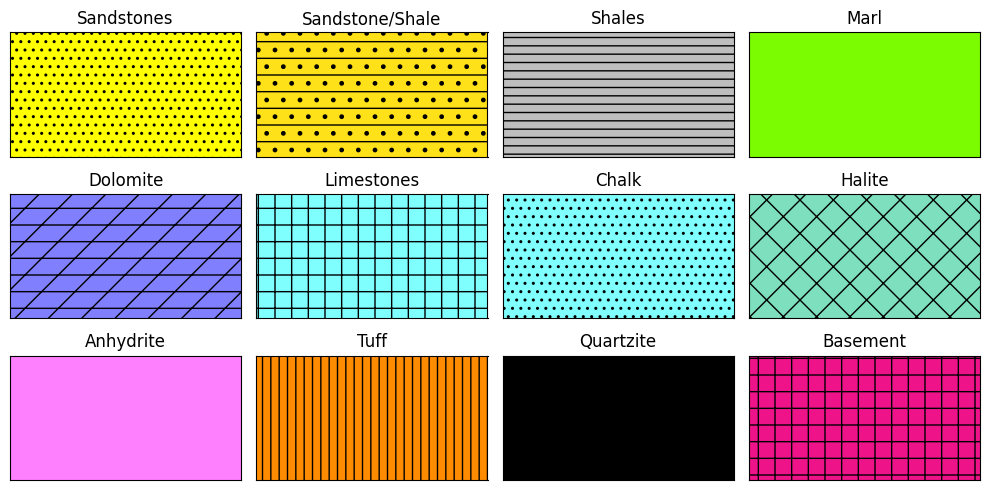

In [ ]:
y = [0, 1]
x = [1, 1]

fig, axes = plt.subplots(ncols=4,nrows=3, sharex=True, sharey=True,
                         figsize=(10,5), subplot_kw={'xticks': [], 'yticks': []})

for ax, key in zip(axes.flat, lithology_numbers.keys()):
    ax.plot(x, y)
    ax.fill_betweenx(y, 0, 1, facecolor=lithology_numbers[key]['color'], hatch=lithology_numbers[key]['hatch'])
    ax.set_xlim(0, 0.1)
    ax.set_ylim(0, 1)
    ax.set_title(str(lithology_numbers[key]['lith']))

plt.tight_layout()

plt.show()

### Step 1, 2, 3

Step 1. Decompaction (decompacted thickness).

Step 2. Correction for paleobathymetry and eustasy (Decompacted depth with corrction).

Step 3. Removal effect of sediment load (porosity, density).



In [16]:
def decomp_func(y1, y2, y1_d, phi, c):  # возвращает фун-ию одной переменной, для которой затем подбирается параметр y2_d

    y2_d = (np.exp(-np.log(e) * y1_d * c) * phi * np.log(e) - \
            np.exp(-np.log(e) * y1 * c) * phi * np.log(e) + \
            np.exp(-np.log(e) * y2 * c) * phi * np.log(e) - \
            np.log(e) * y1 * c + np.log(e) * y1_d * c + np.log(e) * y2 * c + \
            lambertw(-np.log(e) * phi * np.exp(-np.exp(-np.log(e) * y1_d * c) * phi * np.log(e) +\
                                               np.exp(-np.log(e) * y1 * c) * phi * np.log(e) - \
                                               np.exp(-np.log(e) * y2 * c) * phi * np.log(e) + \
                                               np.log(e) * y1 * c - \
                                               np.log(e) * y1_d * c - np.log(e) * y2 * c))) / c / np.log(e)
    return y2_d.real

In [17]:
#считает скорректированную декомпактированную глубину
def corrected(depth, RoMantle, RoWater, sea_level, sea_level_today):
  return depth - sea_level_today * (RoWater / (RoMantle - RoWater)) + (sea_level - sea_level_today)

In [18]:
### the averaeg porosity of a stratigraphic unit at any depth [A.58.6]
def porosity_func(surface_porosity, exp_decay, y1, y2, thicknesses):
  return surface_porosity/exp_decay*((np.exp(-exp_decay*y1) - np.exp(-exp_decay*y2))/thicknesses)

In [19]:
def bulk_density(porosity, RoGrain, RoWater):
  return porosity*RoWater + (1-porosity)*RoGrain

In [20]:
def bulk_density_column(porosity, RoGrain, RoWater):
  return porosity*RoWater + (1-porosity)*RoGrain

In [61]:
def tectonic_subsidence (RoMantle, RoWater, RoColumn, depth):
  return depth*((RoMantle-RoColumn)/(RoMantle-RoWater))

In [ ]:

# decompaction_df = pd.DataFrame() ### <-- Decompacted thicknesses (km). Table A58.3

# age = list(df_well['Age (Ma)'][1:])

# for i, a in enumerate(age, start=0):
#     print('Age', a)

#     work_layers_copy = work_layers.copy()
#     rows_to_delete = []
#     thinkness_list = []

#     for row_index, row in enumerate(work_layers_copy[i::].itertuples(), start=i):

#       lithology = work_layers_copy.at[row.Index, 'Lithology_type']
#       layers_name = work_layers_copy.at[row.Index, 'Event_name']

#       if row_index == i: #<--- если первый слов, то y1 decompaced = 0
#         y1_d = 0

#       else:
#         y1_d = y2_d

#       phi0 = df_constast.loc[df_constast['Lithology_type'] == str(lithology), 'Porosity'].iloc[0]
#       c = df_constast.loc[df_constast['Lithology_type'] == str(lithology), 'Exp_decay, km-1'].iloc[0]
#       y1 = df_well.loc[df_well['Event_name'] == str(layers_name), 'Depth top, m'].iloc[0]
#       y2 = df_well.loc[df_well['Event_name'] == str(layers_name), 'Depth bottom, m'].iloc[0]

#       y2_d = decomp_func(y1, y2, y1_d, phi0, c)

#       thicknesses = np.round(y2_d - y1_d, 3) #A58.3
#       thinkness_list.append(thicknesses)

#       print(row_index, lithology, layers_name, thicknesses)
#     print(sum(thinkness_list), end='\n\n')

#     ### Save result in table
#     resized_list = np.zeros(10)
#     resized_list[:len(thinkness_list)] = thinkness_list

#     new_col_values = resized_list[::-1]
#     new_col_name = f'{a} Ma'
#     decompaction_df[new_col_name] = new_col_values

In [159]:
work_layers

,Well,Event_name,Event_type,Lithology_type,Age (Ma),"Depth top, m","Depth bottom, m","Thickness, m","D Thickness (erosion), m","Paleobathymetry, Ma","Sea level, m",Sublayers,N sublayers,PSE,Kinetic,"TOC initial, %","HI initial, %"
0,Test_well,Layer 10,Erosion,Shales,0.0,0.000000,0.200000,200.000000,NaN,300,0,NaN,NaN,NaN,NaN,NaN,NaN
1,Test_well,Layer 9_1,Deposition,Sandstones,45.0,0.200000,0.250000,50.000000,NaN,325,40,On,5.0,NaN,NaN,NaN,NaN
2,Test_well,Layer 9_2,Deposition,Sandstones,47.0,0.250000,0.300000,50.000000,NaN,325,40,On,5.0,NaN,NaN,NaN,NaN
3,Test_well,Layer 9_3,Deposition,Sandstones,49.0,0.300000,0.350000,50.000000,NaN,325,40,On,5.0,NaN,NaN,NaN,NaN
4,Test_well,Layer 9_4,Deposition,Sandstones,51.0,0.350000,0.400000,50.000000,NaN,325,40,On,5.0,NaN,NaN,NaN,NaN
5,Test_well,Layer 9_5,Deposition,Sandstones,53.0,0.400000,0.450000,50.000000,NaN,325,40,On,5.0,NaN,NaN,NaN,NaN
6,Test_well,Layer 8,Deposition,Shales,55.0,0.450000,1.200000,750.000000,NaN,350,50,NaN,NaN,Reservoir,NaN,NaN,NaN
7,Test_well,Layer 7_1,Deposition,Chalk,80.0,1.200000,1.330000,130.000000,NaN,300,100,On,10.0,NaN,NaN,NaN,NaN
8,Test_well,Layer 7_2,Deposition,Chalk,82.0,1.330000,1.460000,130.000000,NaN,300,100,On,10.0,NaN,NaN,NaN,NaN
9,Test_well,Layer 7_3,Deposition,Chalk,84.0,1.460000,1.590000,130.000000,NaN,300,100,On,10.0,NaN,NaN,NaN,NaN


In [163]:
initial_depth_values = []

decompaction_df = pd.DataFrame() ### <-- Decompacted thicknesses (km). Table A58.3
decompaction_corrected_df = pd.DataFrame() ### <-- Decompacted thicknesses (km). Table A58.4
porosity_df = pd.DataFrame() ### <-- Porosities as a function of time for 10 lithological units undergoing progressive compaction during burial.
                            ### Table A58.4
density_df = pd.DataFrame()
density_column_df = pd.DataFrame()


age_list = list(work_layers['Age (Ma)'])
age_list.append(list(df_well['Age (Ma)'])[-1])
print(age_list)


for i, age in enumerate(age_list, start=0):

    work_layers_copy = work_layers.copy()

    thinkness_list = []
    thinkness_corrected_list = []
    porosity_average_list = []
    porosity_test = []
    density_list = []
    density_column = []
    density_column_total = []


    print('Age', age)

    RoWater, RoMantle = 1000, 3300

### расчет corrected_decompaction for Fundament (not in work_layer)
    if int(age) == age_list[-1]:
      depth = 0
      y2_d_corrected = abs(np.round(corrected(depth, RoMantle, RoWater, sea_level, sea_level_today), 3))
      thinkness_corrected_list.append(y2_d_corrected)

### расчет для слоев с заданной литологией (work_layers)
    for row_index, row in enumerate(work_layers_copy[i::].itertuples(), start=i):

      lithology = work_layers_copy.at[row.Index, 'Lithology_type']
      layers_name = work_layers_copy.at[row.Index, 'Event_name']

      sea_level = work_layers_copy.loc[work_layers_copy['Lithology_type'] == str(lithology), 'Paleobathymetry, Ma'].iloc[0]/1000
      sea_level_today = work_layers_copy.loc[work_layers_copy['Lithology_type'] == str(lithology), 'Sea level, m'].iloc[0]/1000


      phi0 = df_constast.loc[df_constast['Lithology_type'] == str(lithology), 'Porosity'].iloc[0]
      c = df_constast.loc[df_constast['Lithology_type'] == str(lithology), 'Exp_decay, km-1'].iloc[0]
      RoGrain = df_constast.loc[df_constast['Lithology_type'] == str(lithology), 'Grain density'].iloc[0]

      # print(row_index, lithology, layers_name, phi0, sea_level)

      # y1 = df_well.loc[df_well['Event_name'] == str(layers_name), 'Depth top, m'].iloc[0]
      # y2 = df_well.loc[df_well['Event_name'] == str(layers_name), 'Depth bottom, m'].iloc[0]

      y1 = work_layers_copy.loc[work_layers_copy['Event_name'] == str(layers_name), 'Depth top, m'].iloc[0]
      y2 = work_layers_copy.loc[work_layers_copy['Event_name'] == str(layers_name), 'Depth bottom, m'].iloc[0]

      if int(age) == 0:
        initial_depth_values.append(y1)


      if row_index == i: #<--- если первый слов, то y1 decompaced = 0
        y1_d = 0
        if age == 0:
          pass
        else:
          y1_d_corrected = corrected(y1_d, RoMantle, RoWater, sea_level, sea_level_today)
          thinkness_corrected_list.append(y1_d_corrected)

      else:
        y1_d = y2_d
        y1_d_corrected = y2_d_corrected


### decompaction depth
      y2_d = decomp_func(y1, y2, y1_d, phi0, c)
      thicknesses = y2_d - y1_d #A58.3
      thinkness_list.append(np.round(thicknesses, 3))
      # print(row_index, lithology, layers_name, phi0, c, RoGrain, thicknesses)
### corrected decompaction depth
      y2_d_corrected = corrected(y2_d, RoMantle, RoWater, sea_level, sea_level_today)
      thinkness_corrected_list.append(y2_d_corrected)
### porosity
      porosity = np.round(porosity_func(phi0, c, y1_d, y2_d, thicknesses), 3)
      porosity_average_list.append(np.round(porosity, 3))

### Density
      density = bulk_density(porosity, RoGrain, RoWater)
      density_list.append(int(np.round(density, 2)))

      # print(row_index, lithology, layers_name, phi0, c, density)

### Density of entire sediment column [A58.5]
      a = (porosity*RoWater + (1-porosity)*RoGrain)*thicknesses
      density_column.append(a)

    if int(age) == age_list[-1]:
      pass
      density_col = 0
      density_column_total.append(density_col)
    else:
      density_col = sum(density_column)/sum(thinkness_list)
      density_column_total.append(np.round(density_col, 3))
      # print(sum(thinkness_list), density_col, end='\n\n')


 ### Save results in table
    new_col_name = f'{age}'

    ### Save result for decompaction in table
    resized_list_new = np.zeros(work_layers_copy.shape[0])
    resized_list_new[len(resized_list_new) - len(thinkness_list):] = thinkness_list


    # resized_list = np.zeros(work_layers_copy.shape[0])
    # resized_list[:len(thinkness_list)] = thinkness_list

    new_col_values = resized_list_new
    decompaction_df[new_col_name] = new_col_values

    # ### Save result for corrected decompaction in table
    resized_list_new = np.zeros(work_layers_copy.shape[0])
    resized_list_new[len(resized_list_new) - len(thinkness_corrected_list):] = thinkness_corrected_list

    new_col_values_new = resized_list_new
    decompaction_corrected_df[new_col_name] = new_col_values_new

    ### Save result for average porosity in table
    resized_list = np.zeros(work_layers_copy.shape[0])
    resized_list[len(resized_list) - len(porosity_average_list):] = porosity_average_list
    new_col_values = resized_list
    porosity_df[new_col_name] = new_col_values

### Save result for the bulk density in table
    resized_list = np.zeros(work_layers_copy.shape[0])
    resized_list[len(resized_list) - len(density_list):] = density_list
    new_col_values = resized_list
    density_df[new_col_name] = new_col_values

### Save result for the bulk density of column
    density_column_df[new_col_name] = density_column_total

[0.0, 45.0, 47.0, 49.0, 51.0, 53.0, 55.0, 80.0, 82.0, 84.0, 86.0, 88.0, 90.0, 92.0, 94.0, 96.0, 98.0, 100.0, 112.5, 125.0, 145.0, 160.0, 210.0, 222.5, 235.0, 247.5, 245.0, 247.5, 250.0, 252.5, 255.0, 257.5, 260]
Age 0.0
Age 45.0
Age 47.0
Age 49.0
Age 51.0
Age 53.0
Age 55.0
Age 80.0
Age 82.0
Age 84.0
Age 86.0
Age 88.0
Age 90.0
Age 92.0
Age 94.0
Age 96.0
Age 98.0
Age 100.0
Age 112.5
Age 125.0
Age 145.0
Age 160.0
Age 210.0
Age 222.5
Age 235.0
Age 247.5
Age 245.0
Age 247.5
Age 250.0
Age 252.5
Age 255.0
Age 257.5
Age 260


In [161]:
porosity_df

,0.0,45.0,47.0,49.0,51.0,53.0,55.0,80.0,82.0,84.0,...,210.0,222.5,235.0,247.5,245.0,250.0,252.5,255.0,257.5,260
0,0.599,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0
1,0.461,0.487,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0
2,0.455,0.480,0.487,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0
3,0.449,0.473,0.480,0.486,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0
4,0.443,0.466,0.473,0.479,0.486,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0
5,0.437,0.460,0.466,0.473,0.479,0.486,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0
6,0.416,0.453,0.463,0.473,0.484,0.495,0.507,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0
7,0.285,0.314,0.322,0.330,0.338,0.346,0.354,0.640,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0
8,0.260,0.285,0.292,0.299,0.306,0.313,0.320,0.542,0.638,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0
9,0.237,0.259,0.265,0.271,0.277,0.284,0.290,0.470,0.538,0.636,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0


In [ ]:
# density_column_df

#### Function to save to csv

In [32]:
# File save
def save_to_csv(pd_name, work_layers, output_filename):
    work_layers.reset_index(drop=True, inplace=True)
    pd_name['Event_name'] = work_layers['Event_name']
    pd_name['Lithology_type'] = work_layers['Lithology_type']
    pd_name = pd_name[pd_name.columns[::-1]]

    pd_name.to_csv(output_filename, index=True)

In [33]:
save_to_csv(porosity_df, work_layers, "Porosity-2")

In [164]:
decompaction_df.loc['Stratigraphic thickness (km)', :] = decompaction_df.sum(axis=0) # <-- ввод общией мощности

### добавление колонок Lithology_typeб	Event_name
work_layers.reset_index(drop=True, inplace=True)
decompaction_df['Event_name'] = work_layers['Event_name']
decompaction_df['Lithology_type'] = work_layers['Lithology_type']
decompaction_df = decompaction_df[decompaction_df.columns[::-1]]

decompaction_df.to_csv('/content/Decompaction.csv', index=True)

In [165]:
### добавление колонок Lithology_type,	Event_name
# work_layers.reset_index(drop=True, inplace=True)
decompaction_corrected_df['Event_name'] = work_layers['Event_name']
decompaction_corrected_df['Lithology_type'] = work_layers['Lithology_type']
decompaction_corrected_df = decompaction_corrected_df[decompaction_corrected_df.columns[::-1]]

decompaction_corrected_df.to_csv('/content/Decompaction_corrected.csv', index=True)

In [166]:
### добавление колонок Lithology_type,	Event_name
work_layers.reset_index(drop=True, inplace=True)
porosity_df['Event_name'] = work_layers['Event_name']
porosity_df['Lithology_type'] = work_layers['Lithology_type']
porosity_df = porosity_df[porosity_df.columns[::-1]]

porosity_df.to_csv('/content/Porosity.csv', index=True)

In [167]:
### добавление колонок Lithology_type,	Event_name
work_layers.reset_index(drop=True, inplace=True)
density_df['Event_name'] = work_layers['Event_name']
density_df['Lithology_type'] = work_layers['Lithology_type']
density_df = density_df[density_df.columns[::-1]]

density_df.to_csv('/content/Density.csv', index=True)

In [168]:
### добавление колонок Lithology_type,	Event_name
work_layers.reset_index(drop=True, inplace=True)
density_column_df['Event_name'] = work_layers['Event_name']
density_column_df['Lithology_type'] = work_layers['Lithology_type']
density_column_df = density_column_df[density_column_df.columns[::-1]]

density_column_df.to_csv('/content/Density_column.csv', index=True)

#### Plot: "Porosity - Depth" (Comparison with Petromod)

In [ ]:
# Petromod

data_ref = pd.read_excel('/content/BM/Charts_Petromod.xlsx', sheet_name='Petromod porosity', skiprows=0, header=0, engine='openpyxl')
data_ref = data_ref.applymap(lambda x: x.split('\t') if isinstance(x, str) else x)

depth_dc, porosity_plot = [],[]

# Create a sample DataFrame with shape 10x2
depth_dc = decompaction_corrected_df['0'].tolist()
porosity_plot = data_ref[0].tolist()

data = {
    'porosity': porosity_plot,
    'depth_dc': depth_dc
}
df = pd.DataFrame(data)

# # Repeat each column in order like 1 cell, 1 cell, 2 cell, 2 cell, 3 cell, 3 cell
# new_data = {key: [val for val in df[key] for _ in range(2)] for key in df.columns}



# Rewrite the dictionary comprehension as a list comprehension
new_data_list = [(key, [val for val in df[key] for _ in range(2)]) for key in df.columns]
new_data_list[0][1].append(0)
new_data_list[1][1].insert(0, 0)

# Display the new_data_list
print(new_data_list[0][1])

# Convert the list of tuples to a dictionary
data_dict = {key: value for key, value in new_data_list}

# Create a DataFrame from the dictionary
new_df_ref = pd.DataFrame(data_dict)

ValueError: All arrays must be of the same length

In [ ]:
# Calculated data

depth_dc, porosity_plot = [],[]

# Create a sample DataFrame with shape 10x2
depth_dc = decompaction_corrected_df['0'].tolist()
porosity_plot = porosity_df['0'].tolist()

data = {
    'porosity': porosity_plot,
    'depth_dc': depth_dc
}
df = pd.DataFrame(data)

# # Repeat each column in order like 1 cell, 1 cell, 2 cell, 2 cell, 3 cell, 3 cell
# new_data = {key: [val for val in df[key] for _ in range(2)] for key in df.columns}



# Rewrite the dictionary comprehension as a list comprehension
new_data_list = [(key, [val for val in df[key] for _ in range(2)]) for key in df.columns]
new_data_list[0][1].append(0)
new_data_list[1][1].insert(0, 0)

# Display the new_data_list
print(new_data_list[0][1])

# Convert the list of tuples to a dictionary
data_dict = {key: value for key, value in new_data_list}

# Create a DataFrame from the dictionary
new_df = pd.DataFrame(data_dict)

[0.599, 0.599, 0.449, 0.449, 0.416, 0.416, 0.195, 0.195, 0.221, 0.221, 0.049, 0.049, 0.021, 0.021, 0.161, 0.161, 0.02, 0.02, 0.042, 0.042, 0]


In [ ]:

def makeplot_porosity(property, top_depth, bottom_depth):
    # fig = plt.figure(constrained_layout=True, figsize=(10, 6))
    # ax = fig.subplots(1, 2,  sharex=False)

    fig, ax = plt.subplots(figsize=(14,7))

    ax1 = plt.subplot2grid((1,3), (0,0), rowspan=1, colspan = 1)
    ax2 = plt.subplot2grid((1,3), (0,1), rowspan=1, colspan = 1, sharey = ax1)
    ax3 = plt.subplot2grid((1,3), (0,2), rowspan=1, colspan = 1, sharey = ax1)

    # As our curve scales will be detached from the top of the track,
    # this code adds the top border back in without dealing with splines
    # ax10 = ax1.twiny()
    # ax10.xaxis.set_visible(False)

    # ax13 = ax4.twiny()
    # ax13.xaxis.set_visible(False)

### Plot 1
    # Geotherma
    ax1.plot(new_df_ref['porosity'], new_df['depth_dc'], label='Petromod', color='red')
    ax1.plot(new_df['porosity'], new_df['depth_dc'], label='BM', color='black')
    ax1.set_xlabel(f'Porosity', labelpad=20)
    ax1.set_ylabel(f'Depth (km)')
    ax1.legend(loc='upper left')
    ax1.set_xlim(0, 0.6)

### Plot 2
    # Lithology track
    # ax2.plot(T_with_rad_heat["Lithology"], T_with_rad_heat['depth 0'], color = "black", linewidth = 0.5)
    ax2.set_xlabel("Lithology")
    ax2.set_xlim(0, 1)
    ax2.xaxis.label.set_color("black")
    ax2.tick_params(axis='x', colors="black")
    ax2.spines["top"].set_edgecolor("black")
    ax2.set_xticks([0, 1])

    depth_start = 0

    for lit, depth in zip(pd_lithology["Lithology"], decompaction_corrected_df['0']):
        key = int(lit)
        color = lithology_numbers[key]['color']
        hatch = lithology_numbers[key]['hatch']

        depth_values = [depth_start, depth]
        depth_start = depth

        ax2.fill_betweenx(depth_values, 0, 1, facecolor=color, hatch=hatch)

    ax2.set_xticks([0, 1])

### Plot3
    ax3.set_xlabel("Lithology")
    ax3.set_xlim(0, 1)
    ax3.xaxis.label.set_color("black")
    ax3.tick_params(axis='x', colors="black")
    ax3.spines["top"].set_edgecolor("black")
    ax3.set_xticks([0, 1])

    depth_start = 0

    for lit, depth in zip(property["Lithology_type"], decompaction_corrected_df['0']):
        key = lit
        depth_values = [depth_start, depth]
        depth_start = depth

        label_position = (0.5, sum(depth_values) / 2)  # Assuming x position is at 0.5
        ax3.text(label_position[0], label_position[1], key, ha='center', va='center')
        ax3.plot([0, 1], [depth, depth], color='black', linewidth=1)  # Assuming black color and linewidth of 1


    for ax in [ax1, ax2, ax3]:
        ax.set_ylim(bottom_depth, top_depth)
        ax.grid(which='major', color='lightgrey', linestyle='-')
        ax.xaxis.set_ticks_position("top")
        ax.xaxis.set_label_position("top")
        ax.spines["top"].set_position(("axes", 1.02))

    for ax in [ax2]:
        plt.setp(ax.get_yticklabels(), visible = False)

    plt.tight_layout()
    fig.subplots_adjust(wspace = 0.15)
    return plt.savefig("porosity-depth.png")

<ipython-input-267-c92f6cca324a>:7: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax1 = plt.subplot2grid((1,3), (0,0), rowspan=1, colspan = 1)


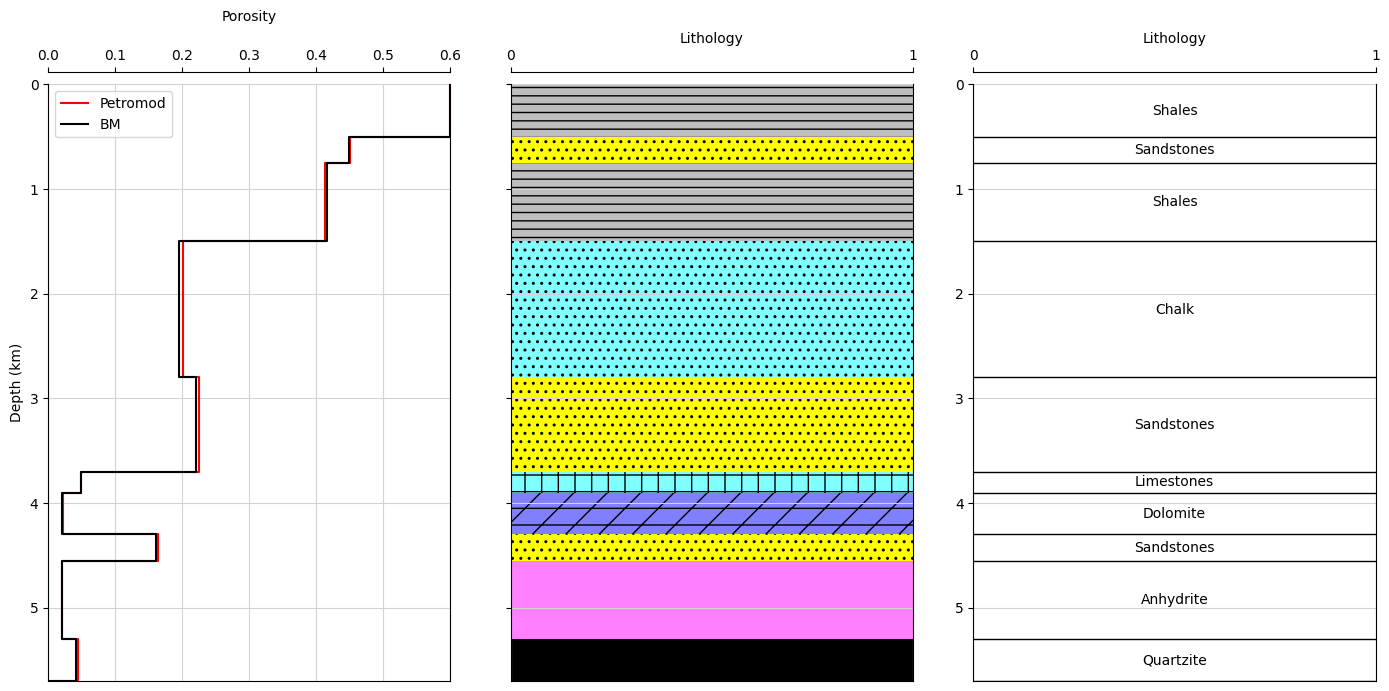

In [ ]:
makeplot_porosity(porosity_df, 0, max(decompaction_corrected_df['0']))

In [ ]:

def makeplot_porosity_2pic(property, top_depth, bottom_depth):
    # fig = plt.figure(constrained_layout=True, figsize=(10, 6))
    # ax = fig.subplots(1, 2,  sharex=False)

    fig, ax = plt.subplots(figsize=(8, 8))

    ax1 = plt.subplot2grid((1,2), (0,0), rowspan=1, colspan = 1)
    ax2 = plt.subplot2grid((1,2), (0,1), rowspan=1, colspan = 1, sharey = ax1)

    # As our curve scales will be detached from the top of the track,
    # this code adds the top border back in without dealing with splines
    # ax10 = ax1.twiny()
    # ax10.xaxis.set_visible(False)

    # ax13 = ax4.twiny()
    # ax13.xaxis.set_visible(False)

### Plot 1
    # Geotherms
    ax1.plot(new_df_ref['porosity'], new_df['depth_dc'], label='Petromod', color='red', lw=3)
    ax1.plot(new_df['porosity'], new_df['depth_dc'], label='BM', color='black', lw=3)

    ax1.set_xlabel(f'Porosity [n/n]', labelpad=20)
    ax1.set_ylabel(f'Depth [km]')
    ax1.legend(loc='upper left')
    ax1.set_xlim(0, 0.6)

    # Lithology
    ax1.xaxis.label.set_color("black")
    ax1.tick_params(axis='x', colors="black")
    ax1.spines["top"].set_edgecolor("black")

    depth_start = 0

    for lit, depth in zip(pd_lithology["Lithology"], decompaction_corrected_df['0']):
        key = int(lit)
        color = lithology_numbers[key]['color']
        hatch = lithology_numbers[key]['hatch']

        depth_values = [depth_start, depth]
        depth_start = depth

        ax1.fill_betweenx(depth_values, 0, 1, facecolor=color, hatch=hatch, alpha=0.2)


### Plot 2
    ax2.set_xlabel("Lithology")
    ax2.set_xlim(0, 1)
    ax2.xaxis.label.set_color("black")
    ax2.tick_params(axis='x', colors="black")
    ax2.spines["top"].set_edgecolor("black")
    ax2.set_xticks([0, 1])

    depth_start = 0

    for lit, depth in zip(property["Lithology_type"], decompaction_corrected_df['0']):
        key = lit
        depth_values = [depth_start, depth]
        depth_start = depth

        label_position = (0.5, sum(depth_values) / 2)  # Assuming x position is at 0.5
        ax2.text(label_position[0], label_position[1], key, ha='center', va='center')
        ax2.plot([0, 1], [depth, depth], color='black', linewidth=1)  # Assuming black color and linewidth of 1


    for ax in [ax1, ax2]:
        ax.set_ylim(bottom_depth, top_depth)
        ax.grid(which='major', color='lightgrey', linestyle='-')
        ax.xaxis.set_ticks_position("top")
        ax.xaxis.set_label_position("top")
        ax.spines["top"].set_position(("axes", 1.02))

    for ax in [ax2]:
        plt.setp(ax.get_yticklabels(), visible = False)

    plt.tight_layout()
    fig.subplots_adjust(wspace = 0.15)
    return plt.savefig("porosity-depth.png")

<ipython-input-269-7f74e9636138>:7: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax1 = plt.subplot2grid((1,2), (0,0), rowspan=1, colspan = 1)


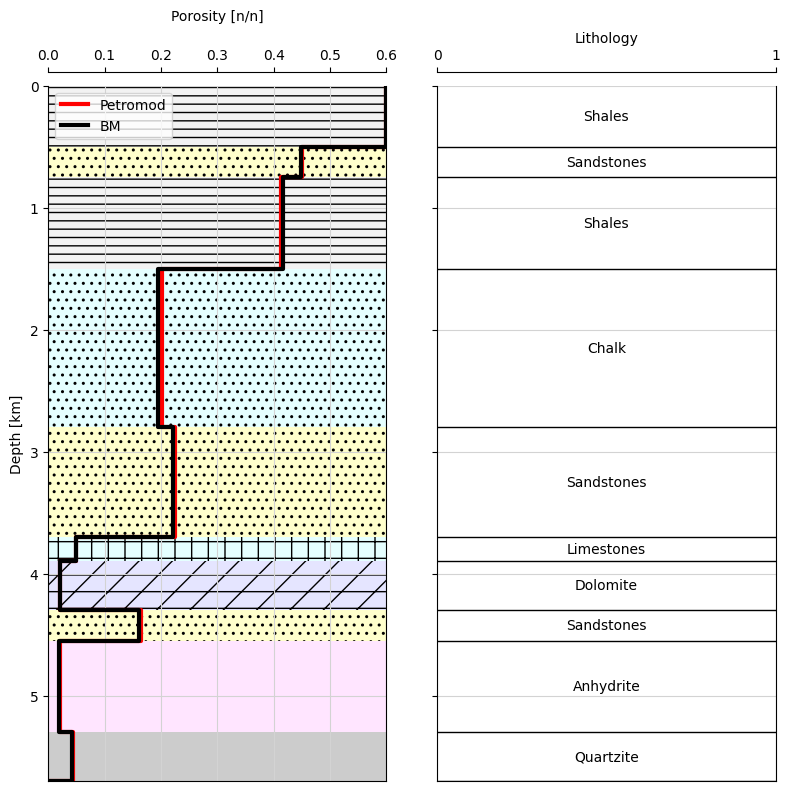

In [ ]:
makeplot_porosity_2pic(porosity_df, 0, max(decompaction_corrected_df['0']))

### Tectonic driving subsidence [A58.7]

In [169]:
work_layers

,Well,Event_name,Event_type,Lithology_type,Age (Ma),"Depth top, m","Depth bottom, m","Thickness, m","D Thickness (erosion), m","Paleobathymetry, Ma","Sea level, m",Sublayers,N sublayers,PSE,Kinetic,"TOC initial, %","HI initial, %"
0,Test_well,Layer 10,Erosion,Shales,0.0,0.000000,0.200000,200.000000,NaN,300,0,NaN,NaN,NaN,NaN,NaN,NaN
1,Test_well,Layer 9_1,Deposition,Sandstones,45.0,0.200000,0.250000,50.000000,NaN,325,40,On,5.0,NaN,NaN,NaN,NaN
2,Test_well,Layer 9_2,Deposition,Sandstones,47.0,0.250000,0.300000,50.000000,NaN,325,40,On,5.0,NaN,NaN,NaN,NaN
3,Test_well,Layer 9_3,Deposition,Sandstones,49.0,0.300000,0.350000,50.000000,NaN,325,40,On,5.0,NaN,NaN,NaN,NaN
4,Test_well,Layer 9_4,Deposition,Sandstones,51.0,0.350000,0.400000,50.000000,NaN,325,40,On,5.0,NaN,NaN,NaN,NaN
5,Test_well,Layer 9_5,Deposition,Sandstones,53.0,0.400000,0.450000,50.000000,NaN,325,40,On,5.0,NaN,NaN,NaN,NaN
6,Test_well,Layer 8,Deposition,Shales,55.0,0.450000,1.200000,750.000000,NaN,350,50,NaN,NaN,Reservoir,NaN,NaN,NaN
7,Test_well,Layer 7_1,Deposition,Chalk,80.0,1.200000,1.330000,130.000000,NaN,300,100,On,10.0,NaN,NaN,NaN,NaN
8,Test_well,Layer 7_2,Deposition,Chalk,82.0,1.330000,1.460000,130.000000,NaN,300,100,On,10.0,NaN,NaN,NaN,NaN
9,Test_well,Layer 7_3,Deposition,Chalk,84.0,1.460000,1.590000,130.000000,NaN,300,100,On,10.0,NaN,NaN,NaN,NaN


In [205]:
density_column_test

,260,257.5,255.0,252.5,250.0,245.0,247.5,235.0,222.5,210.0,...,84.0,82.0,80.0,55.0,53.0,51.0,49.0,47.0,45.0,0.0
0,0,2316.479,2327.461,2328.901,2334.992,2342.339,2343.093,2602.813,2659.36,2697.864,...,2346.359,2354.317,2358.262,2382.724,2385.819,2388.961,2390.907,2392.672,2394.919,2394.799


In [299]:
### Tectonic driving subsidence [A58.7]
output_df = pd.DataFrame()
RoWater, RoMantle = 1000, 3300
# y = tectonic_subsidence(RoMantle, RoWater, density_column, thicknesses)

# decompaction_corrected_df.iloc[2:]
thicknesses = decompaction_corrected_df.iloc[:, 2:decompaction_corrected_df.shape[1]]
density_column_test = density_column_df.iloc[:, 2:density_column_df.shape[1]]


# Initialize an empty list to store the output values
output_values = []


col_name = list(density_column_test.columns)

for columns2, column_name in zip(thicknesses.columns, density_column_test.columns):
  if all(item == 0 for item in density_column_test[column_name].values):
    y = tectonic_subsidence(RoMantle, RoWater,
                            np.zeros(len(density_column_test[column_name].values)),
                            np.zeros(len(thicknesses[columns2].values)))

    output_values.append(y)

  else:
      y = tectonic_subsidence(RoMantle, RoWater,
                              density_column_test[column_name].values,
                              thicknesses[columns2].values)
      output_values.append(y)

output_df = pd.DataFrame(output_values).T[::-1].rename(columns=dict(enumerate(col_name)))

In [303]:
output_df

,260,257.5,255.0,252.5,250.0,245.0,247.5,235.0,222.5,210.0,...,84.0,82.0,80.0,55.0,53.0,51.0,49.0,47.0,45.0,0.0
31,0.0,0.034109,0.067233,0.100375,0.132571,0.196126,0.163811,0.256469,0.287872,0.319608,...,1.875300,1.903779,1.937600,2.068018,2.070025,2.072049,2.076896,2.082245,2.086547,2.125255
30,0.0,0.000000,0.033700,0.067077,0.099660,0.163798,0.131345,0.233457,0.266940,0.300120,...,1.847307,1.876068,1.910049,2.041356,2.043462,2.045585,2.050497,2.055905,2.060281,2.099017
29,0.0,0.000000,0.000000,0.033621,0.066599,0.131333,0.098737,0.210365,0.245942,0.280576,...,1.819307,1.848350,1.882492,2.014693,2.016897,2.019120,2.024096,2.029564,2.034013,2.072779
28,0.0,0.000000,0.000000,0.000000,0.033381,0.098728,0.065982,0.187190,0.224875,0.260974,...,1.791298,1.820625,1.854929,1.988028,1.990330,1.992653,1.997694,2.003222,2.007745,2.046541
27,0.0,0.000000,0.000000,0.000000,0.000000,0.065974,0.033071,0.163929,0.203738,0.241313,...,1.763281,1.792894,1.827360,1.961361,1.963762,1.966185,1.971291,1.976879,1.981476,2.020304
26,0.0,0.000000,0.000000,0.000000,0.000000,0.033067,0.000000,0.140579,0.182528,0.221590,...,1.735255,1.765155,1.799785,1.934693,1.937192,1.939715,1.944887,1.950535,1.955206,1.994066
25,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.123199,0.166812,0.207039,...,1.715513,1.745632,1.780393,1.915999,1.918571,1.921166,1.926387,1.932080,1.936806,1.975700
24,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.064667,0.113127,0.156671,...,1.637483,1.668290,1.703409,1.841158,1.843989,1.846848,1.852234,1.858078,1.862994,1.901906
23,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.006062,0.059381,0.106250,...,1.559441,1.590939,1.626417,1.766315,1.769405,1.772527,1.778080,1.784075,1.789181,1.828112
22,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.005571,0.055772,...,1.481387,1.513578,1.549416,1.691469,1.694819,1.698205,1.703923,1.710070,1.715367,1.754319


#### Plot: "Tectonic subsidence Y after decompaction and backstripping" (Comparison with Petromod) [Fig. A58.2]


ValueError: x and y must have same first dimension, but have shapes (12198,) and (32,)

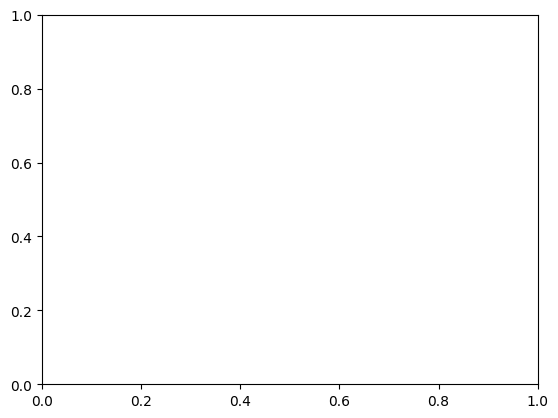

In [301]:
# work_layers = decompaction_corrected_df.drop(['Lithology_type', 'Event_name'], axis=1, inplace=False)
# age_values = [int(age.split(' Ma')[0]) for age in work_layers.columns.tolist()]
age_values  = [int(age) for age in work_layers['Age (Ma)'][0:]][::-1]
# age_values = list(df_well['Age (Ma)'][1:])[::-1]

# work_layers_copy = work_layers.copy()

# # Plot the lines for each row in work_layers_copy
for row_index, row in output_df.iterrows():
    plt.plot(age_values, row.values)

# # Calculate sea level and sea level today
# sea_level = df_well[1:df_well.shape[0]]['Paleobathymetry, Ma'] / 1000
# sea_level_today = df_well[1:df_well.shape[0]]['Sea level, m'] / 1000

# # Plot sea level and present-day sea level
# plt.plot(age_values, (abs(sea_level - sea_level_today))[::-1], 'k--', label='Sea level')
# plt.plot(age_values, np.zeros(work_layers_copy.shape[1]), 'k--', label='present-day sea level')

# # Fill the space between the two sea level plots with blue color
# plt.fill_between(age_values, np.zeros(work_layers_copy.shape[1]),
#  (abs(sea_level - sea_level_today))[::-1], color='blue', alpha=0.2, label='Sea level' )

# Additional plotting settings
plt.gca().invert_yaxis()
plt.gca().invert_xaxis()
plt.axis([np.round(max(age_values), -2), np.min(age_values), np.max(output_df)+0.5, 0])

plt.tick_params(axis='x', which='both', bottom=False, top=True, labelbottom=False, labeltop=True)
plt.tick_params(axis='y', which='both', left=False, right=True, labelleft=False, labelright=True)

# Move the x-axis label to the top
plt.xlabel(f'Age (Ma)', labelpad=20)
plt.ylabel(f'Tectonic subsidence (water-loaded) (km)')
plt.gca().xaxis.set_label_coords(0.5, 1.15)

plt.legend()
plt.grid(color='gray', linestyle='--', linewidth=0.5)

# Display the plot
plt.show()

In [ ]:
# Data reference Petromod
data_ref = pd.read_excel('/content/BM/Charts_Petromod.xlsx', sheet_name='Petromod Depth', skiprows=0, header=0, engine='openpyxl')
data_ref = data_ref.applymap(lambda x: x.split('\t') if isinstance(x, str) else x)

In [ ]:
plt.figure(figsize=(8, 7))

    # Our data
work_layers = decompaction_corrected_df.drop(['Lithology_type', 'Event_name'], axis=1, inplace=False)
age_values = [int(age.split(' Ma')[0]) for age in work_layers.columns.tolist()]
work_layers_copy = work_layers.copy()

# Plot the lines for each row in work_layers_copy
for row_index, row in work_layers_copy.iterrows():
  plt.plot(age_values, row.values, linestyle='solid')

    # Petromode
work_layers = data_ref.drop(['Unnamed: 0', 'Lithology_type', 'Event_name'], axis=1, inplace=False)
work_layers_copy = work_layers.copy()

for row_index, row in work_layers_copy.iterrows():
  plt.plot(age_values, row.values, linestyle='dashed')

# Calculate sea level and sea level today
sea_level = df_well[1:df_well.shape[0]]['Paleobathymetry, Ma'] / 1000
sea_level_today = df_well[1:df_well.shape[0]]['Sea level, m'] / 1000

# # Plot sea level and present-day sea level
# plt.plot(age_values, (abs(sea_level - sea_level_today))[::-1], 'k--', label='Sea level')
# plt.plot(age_values, np.zeros(work_layers_copy.shape[1]), 'k--', label='present-day sea level')

# Fill the space between the two sea level plots with blue color
plt.fill_between(age_values, np.zeros(work_layers_copy.shape[1]),
 (abs(sea_level - sea_level_today))[::-1], color='blue', alpha=0.2, label='Sea level' )

# Additional plotting settings
plt.gca().invert_yaxis()
plt.gca().invert_xaxis()
# plt.axis([np.round(max(age_values), -2), np.min(age_values), np.max(work_layers_copy), -1])
plt.axis([262, 0, np.max(work_layers_copy), 0])

plt.tick_params(axis='x', which='both', bottom=False, top=True, labelbottom=False, labeltop=True)
# plt.tick_params(axis='y', which='both', left=False, right=True, labelleft=False, labelright=True)

# Move the x-axis label to the top
plt.xlabel(f'Millions years before present', labelpad=10, fontsize=12)
plt.ylabel(f'Depth(km)', labelpad=10, fontsize=12)
plt.gca().xaxis.set_label_coords(0.5, 1.15)

plt.legend(loc='lower left')
plt.grid(color='gray', linestyle='--', linewidth=0.5)

# Display the plot
plt.show()
plt.savefig("age-depth.png")

ValueError: invalid literal for int() with base 10: '245.0'

<Figure size 800x700 with 0 Axes>

### Step 4: Thermal conductivity of the basin-fill

In [218]:
def bulk_thermal_conductivity(tc_matrix, tc_inclusion, porosity):
  return tc_matrix*(1-porosity) + tc_inclusion*porosity

In [219]:
def bulk_thermal_conductivity_geomean(tc_matrix, tc_inclusion, porosity):
  return tc_inclusion**porosity * tc_matrix**(1-porosity)

In [220]:
def geotherm_constant_heat(surface_T, basal_HF, depth, tc_bulk):
  return surface_T + (-basal_HF*depth * tc_bulk**-1)

In [221]:
work_layers = df_well[1:df_well.shape[0]-1] ### Слои, по которым идет расчет
work_layers

,Well,Event_name,Event_type,Lithology_type,Age (Ma),"Depth top, m","Depth bottom, m","Thickness, m","D Thickness (erosion), m","Paleobathymetry, Ma","Sea level, m",Sublayers,N sublayers,PSE,Kinetic,"TOC initial, %","HI initial, %"
1,Test_well,Layer 10,Erosion,Shales,0,0.00,0.20,200,NaN,300,0,NaN,NaN,NaN,NaN,NaN,NaN
2,Test_well,Layer 9,Deposition,Sandstones,45,0.20,0.45,250,NaN,325,40,On,5.0,NaN,NaN,NaN,NaN
3,Test_well,Layer 8,Deposition,Shales,55,0.45,1.20,750,NaN,350,50,NaN,NaN,Reservoir,NaN,NaN,NaN
4,Test_well,Layer 7,Deposition,Chalk,80,1.20,2.50,1300,NaN,300,100,On,10.0,NaN,NaN,NaN,NaN
5,Test_well,Layer 6,Deposition,Sandstones,100,2.50,3.40,900,NaN,200,80,On,2.0,NaN,NaN,NaN,NaN
6,Test_well,Layer 5,Deposition,Limestones,125,3.40,3.60,200,NaN,20,70,NaN,NaN,NaN,NaN,NaN,NaN
7,Test_well,Layer 4,Deposition,Dolomite,145,3.60,4.00,400,NaN,20,-40,NaN,NaN,Reservoir,NaN,NaN,NaN
8,Test_well,Layer 3,Deposition,Sandstones,160,4.00,4.25,250,NaN,10,-20,NaN,NaN,NaN,NaN,NaN,NaN
9,Test_well,Layer 2,Deposition,Anhydrite,210,4.25,5.00,750,NaN,20,0,On,4.0,NaN,NaN,NaN,NaN
10,Test_well,Layer 1,Deposition,Quartzite,245,5.00,5.40,400,NaN,0,0,On,6.0,NaN,NaN,NaN,NaN


In [228]:
work_layers = layers_subdivision(work_layers, on=True)

3 2
5 4
6 5
Well                         Test_well
Event_name                   Fundament
Event_type                  Deposition
Lithology_type                     NaN
Age (Ma)                           260
Depth top, m                       5.4
Depth bottom, m                    5.4
Thickness, m                         0
D Thickness (erosion), m           NaN
Paleobathymetry, Ma                -20
Sea level, m                        10
Sublayers                          NaN
N sublayers                        NaN
PSE                                NaN
Kinetic                            NaN
TOC initial, %                     NaN
HI initial, %                      NaN
Name: 11, dtype: object
Well                         Test_well
Event_name                   Fundament
Event_type                  Deposition
Lithology_type                     NaN
Age (Ma)                           260
Depth top, m                       5.4
Depth bottom, m                    5.4
Thickness, m                

In [229]:
tc_bulk_df = pd.DataFrame()

age_list = list(work_layers['Age (Ma)'][0:])
print(age_list)

for i, age in enumerate(age_list, start=0):

    work_layers_copy = work_layers.copy()
    print(age)

    tc_bulk_list = []

    # thinkness_list = []
    # thinkness_corrected_list = []
    # porosity_average_list = []
    # porosity_test = []
    # density_list = []
    # density_column = []
    # density_column_total = []

    RoWater, RoMantle = 1000, 3300
    tc_water = 0.60

    sea_level = work_layers_copy.loc[work_layers_copy['Lithology_type'] == str(lithology), 'Paleobathymetry, Ma'].iloc[0]/1000
    sea_level_today = work_layers_copy.loc[work_layers_copy['Lithology_type'] == str(lithology), 'Sea level, m'].iloc[0]/1000

    print('Age', age)

    ### расчет corrected_decompaction for Fundament (not in work_layer)
    if int(age) == age_list[-1]:
          tc_bulk = 0
          tc_bulk_list.append(tc_bulk)


### расчет для слоев с заданной литологией (work_layers)
    for row_index, row in enumerate(work_layers_copy[i::].itertuples(), start=i):

      lithology = work_layers_copy.at[row.Index, 'Lithology_type']
      layers_name = work_layers_copy.at[row.Index, 'Event_name']
      phi0 = porosity_df.loc[(porosity_df['Lithology_type'] == str(lithology)) & (porosity_df['Event_name'] == layers_name), f'{age}'].iloc[0]
      tc_matrix = df_constast.loc[df_constast['Lithology_type'] == str(lithology), 'TC matrix'].iloc[0]

      # c = df_constast.loc[df_constast['Lithology_type'] == str(lithology), 'Exp_decay, km-1'].iloc[0]
      # RoGrain = df_constast.loc[df_constast['Lithology_type'] == str(lithology), 'Grain density'].iloc[0]
      # y1 = df_well.loc[df_well['Event_name'] == str(layers_name), 'Depth top, m'].iloc[0]
      # y2 = df_well.loc[df_well['Event_name'] == str(layers_name), 'Depth bottom, m'].iloc[0]

### Bulk thermal conductivity
      tc_bulk = bulk_thermal_conductivity(tc_matrix, tc_water, phi0)
      # tc_bulk = bulk_thermal_conductivity_geomean(tc_matrix, tc_water, phi0)
      tc_bulk_list.append(tc_bulk)

      print(row_index, lithology, layers_name, phi0, tc_bulk)


### Save results in table
    new_col_name = f'{age}'
    ### Save result for decompaction in table
    resized_list_new = np.zeros(work_layers_copy.shape[0])
    resized_list_new[len(resized_list_new) - len(tc_bulk_list):] = tc_bulk_list
    new_col_values = resized_list_new
    tc_bulk_df[new_col_name] = new_col_values

[0.0, 45.0, 47.0, 49.0, 51.0, 53.0, 55.0, 80.0, 82.0, 84.0, 86.0, 88.0, 90.0, 92.0, 94.0, 96.0, 98.0, 100.0, 112.5, 125.0, 145.0, 160.0, 210.0, 222.5, 235.0, 247.5, 245.0, 247.5, 250.0, 252.5, 255.0, 257.5]
0.0
Age 0.0
0 Shales Layer 10 0.599 1.1614
1 Sandstones Layer 9_1 0.461 3.2411
2 Sandstones Layer 9_2 0.455 3.2704999999999997
3 Sandstones Layer 9_3 0.449 3.2998999999999996
4 Sandstones Layer 9_4 0.443 3.3292999999999995
5 Sandstones Layer 9_5 0.437 3.3587
6 Shales Layer 8 0.416 1.4176000000000002
7 Chalk Layer 7_1 0.285 2.5305
8 Chalk Layer 7_2 0.26 2.598
9 Chalk Layer 7_3 0.237 2.6601
10 Chalk Layer 7_4 0.216 2.7168
11 Chalk Layer 7_5 0.197 2.7680999999999996
12 Chalk Layer 7_6 0.18 2.814
13 Chalk Layer 7_7 0.164 2.8571999999999997
14 Chalk Layer 7_8 0.149 2.8976999999999995
15 Chalk Layer 7_9 0.136 2.9328
16 Chalk Layer 7_10 0.124 2.9652
17 Sandstones Layer 6_1 0.235 4.3485000000000005
18 Sandstones Layer 6_2 0.208 4.4807999999999995
19 Limestones Layer 5 0.049 3.16769999999999

In [230]:
### добавление колонок Lithology_type,	Event_name
work_layers.reset_index(drop=True, inplace=True)
tc_bulk_df['Event_name'] = work_layers['Event_name']
tc_bulk_df['Lithology_type'] = work_layers['Lithology_type']
tc_bulk_df= tc_bulk_df[tc_bulk_df.columns[::-1]]

tc_bulk_df.to_csv('/content/TC_bulk.csv', index=True)

In [231]:
tc_bulk_df

,Lithology_type,Event_name,257.5,255.0,252.5,250.0,245.0,247.5,235.0,222.5,...,84.0,82.0,80.0,55.0,53.0,51.0,49.0,47.0,45.0,0.0
0,Shales,Layer 10,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.1614
1,Sandstones,Layer 9_1,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,3.1137,3.2411
2,Sandstones,Layer 9_2,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,3.1137,3.1480,3.2705
3,Sandstones,Layer 9_3,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,3.1186,3.1480,3.1823,3.2999
4,Sandstones,Layer 9_4,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,3.1186,3.1529,3.1823,3.2166,3.3293
5,Sandstones,Layer 9_5,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,3.1186,3.1529,3.1823,3.2166,3.2460,3.3587
6,Shales,Layer 8,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,1.2902,1.3070,1.3224,1.3378,1.3518,1.3658,1.4176
7,Chalk,Layer 7_1,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,1.5720,2.3442,2.3658,2.3874,2.4090,2.4306,2.4522,2.5305
8,Chalk,Layer 7_2,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,1.5774,1.8366,2.4360,2.4549,2.4738,2.4927,2.5116,2.5305,2.5980
9,Chalk,Layer 7_3,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,1.5828,1.8474,2.0310,2.5170,2.5332,2.5521,2.5683,2.5845,2.6007,2.6601


## Step 5. Calculation of the geotherm with variable thermal conductivity (a constant heat flow from the mantle)



## Step 6. The radiogenic heat contribution: Eqn. [A58.10]

In [232]:
def linear_geotherm(G, y):
  return G*y

In [233]:
def linear_geotherm_2(T0, qm, A, yc, depth, K):
  return T0 + ((-Qm + A*yc)/K)*depth - (A/(2*K)*depth**2)

### Ap.13: Effects of variable radiogenic heating and thermal conductivity on the geotherm in the basin-fill - CHECK

In [239]:
work_layers = layers_subdivision(work_layers, on=True)

In [240]:
T_with_rad_heat = pd.DataFrame()
T_without_rad_heat = pd.DataFrame()
T_linear_geotherm =  pd.DataFrame()

age_list = list(work_layers['Age (Ma)'][1:2])
print(age_list)


for i, age in enumerate(age_list, start=0):

    work_layers_copy = work_layers.copy()

    T_list = []
    T_list_constant = []
    T_linear_geotherm_values = []


    Qm = 0
    T0 = 15
    G = 20

    print('Age', age)


    sum_variables_1, sum_variables_2 = [], []
    sum_variables_3, sum_variables_4 = [], []
    sum_variables_5 = []
    layers_sum = []
    layers_sum_1 = []



### расчет для слоев с заданной литологией (work_layers)
    for row_index, row in enumerate(work_layers_copy[i::].itertuples(), start=i):

      lithology = work_layers_copy.at[row.Index, 'Lithology_type']
      layers_name = work_layers_copy.at[row.Index, 'Event_name']

      A = work_layers.loc[work_layers['Lithology_type'] == str(lithology), 'Layer radiogenic\nheat production'].iloc[0] * 10**-6
      K = work_layers.loc[work_layers['Lithology_type'] == str(lithology), 'Layer bulk\nconductivity'].iloc[0]

      thickness_layer = work_layers.loc[work_layers['Lithology_type'] == str(lithology), 'Thickness, m'].iloc[0]

      crust_depth = 5

      depth = work_layers.loc[work_layers['Lithology_type'] == str(lithology), 'Depth bottom, m'].iloc[0]

### With radio heat
      Qm = 30*10**-3 # Qm = 30 - ни где не указано в книги, сама подобрала
      if K == 0:
        sum_variables_1.append(0)
        sum_variables_2.append(0)
      else:
        layers_sum.append(thickness_layer)
        crust_depth = sum(layers_sum)

        sum_variables_1.append(((Qm+A*crust_depth)/K)*thickness_layer)
        sum_variables_2.append((A/(2*K))*(thickness_layer)**2)


      T = T0 + (sum(sum_variables_1) - sum(sum_variables_2))
      T_list.append(T)

      print(row_index, lithology, crust_depth, thickness_layer, K, A, T_list)



### without radio heat

      Qm = 25*10**-3
      A = 2.5 * 10**-6
      K= 3

###!!!!!!!!!!!!!!!!!!!!!! crust depth = 5km and change for each layer
      layers_sum_1.append(thickness_layer)
      crust_depth = sum(layers_sum_1)
###!!!!!!!!!!!!!!!!!!!!!!
      if K == 0:
        sum_variables_3.append(0)
      else:
        sum_variables_3.append(((Qm+A*crust_depth)/K)*thickness_layer)
        sum_variables_4.append((A/(2*K))*(thickness_layer)**2)

      T_no_heat = T0 + (sum(sum_variables_3) - sum(sum_variables_4))
      T_list_constant.append(T_no_heat)


# ### Linear teady-stage geotherm Appendix 12
      Qm = -60 * 10**-3
      A = 0
      yc = 30 *1000
      K= 3
      depth *=1000

      # T_linear_geotherm_values.append(T0 + ((-Qm + A*yc)/K)*depth - (A/(2*K)*depth**2))

      T_linear_geotherm_values.append(linear_geotherm_2(T0, qm, A, yc, depth, K))

      print(T_list_constant)
      print(T_linear_geotherm_values)

### Save results in table

### with radio heat
    new_col_name = f'{age}'
    ### Save result for decompaction in table
    resized_list_new = np.zeros(work_layers_copy.shape[0])
    resized_list_new[len(resized_list_new) - len(T_list):] = T_list
    new_col_values = resized_list_new
    T_with_rad_heat[new_col_name] = new_col_values

### without radio heat
    resized_list_new = np.zeros(work_layers_copy.shape[0])
    resized_list_new[len(resized_list_new) - len(T_list_constant):] = T_list_constant
    new_col_values = resized_list_new
    T_without_rad_heat[new_col_name] = new_col_values


### Linear teady-stage geotherm Appendix 12
    resized_list_new = np.zeros(work_layers_copy.shape[0])
    resized_list_new[len(resized_list_new) - len(T_list_constant):] = T_linear_geotherm_values
    new_col_values = resized_list_new
    T_linear_geotherm[new_col_name] = new_col_values

[45.0]
Age 45.0


KeyError: 'Layer radiogenic\nheat production'

In [ ]:
T0 = 15
Linear = T_linear_geotherm["0.0"].tolist()
Linear.insert(0, T0)


A_line = T_without_rad_heat["0.0"].tolist()
A_line.insert(0, T0)

C_line = T_with_rad_heat["0.0"].tolist()
C_line.insert(0, T0)

In [ ]:
y = work_layers["Depth bottom, m"].tolist()
y_add = y.insert(0, 0)

print(Linear, y)

plt.figure(figsize=(4, 8))
plt.plot(A_line, y , label='A (A added and constant)', marker='o', color='green')
# plt.plot(T_true['0'], y , label='McKenzie')
plt.plot(Linear, y , label='B Linear Geotherm', marker='o', color='red')
plt.plot(C_line, y , label='C (A & K variable)', marker='o', color='blue')


# plt.axis([np.round(max(age_values), -2), np.min(age_values), np.max(output_df)+0.5, 0])

plt.tick_params(axis='x', which='both', bottom=False, top=True, labelbottom=False, labeltop=True)
# plt.tick_params(axis='y', which='both', left=False, right=True, labelleft=False, labelright=True)

# Move the x-axis label to the top
plt.xlabel(f'Tempreture', labelpad=20)
plt.ylabel(f'Depth (km)')
# plt.gca().xaxis.set_label_coords(0.5, 1.15)

plt.legend()
plt.grid(color='gray', linestyle='--', linewidth=0.5)

plt.xlim(0, 140)
plt.ylim(0, 5)
plt.gca().invert_yaxis()
plt.show()

## Step 7. Calculation of the stretch factor

In [241]:
import warnings
from scipy import stats

warnings.filterwarnings("ignore")
warnings.filterwarnings("default")

In [242]:
from scipy.stats import linregress
from scipy.optimize import fsolve

In [243]:
output_df

,257.5,255.0,252.5,250.0,247.5,245.0,247.5,235.0,222.5,210.0,...,84.0,82.0,80.0,55.0,53.0,51.0,49.0,47.0,45.0,0.0
31,0.0,0.034109,0.067233,0.100375,0.132571,0.196126,0.163811,0.256469,0.287872,0.319608,...,1.875300,1.903779,1.937600,2.068018,2.070025,2.072049,2.076896,2.082245,2.086547,2.125255
30,0.0,0.000000,0.033700,0.067077,0.099660,0.163798,0.131345,0.233457,0.266940,0.300120,...,1.847307,1.876068,1.910049,2.041356,2.043462,2.045585,2.050497,2.055905,2.060281,2.099017
29,0.0,0.000000,0.000000,0.033621,0.066599,0.131333,0.098737,0.210365,0.245942,0.280576,...,1.819307,1.848350,1.882492,2.014693,2.016897,2.019120,2.024096,2.029564,2.034013,2.072779
28,0.0,0.000000,0.000000,0.000000,0.033381,0.098728,0.065982,0.187190,0.224875,0.260974,...,1.791298,1.820625,1.854929,1.988028,1.990330,1.992653,1.997694,2.003222,2.007745,2.046541
27,0.0,0.000000,0.000000,0.000000,0.000000,0.065974,0.033071,0.163929,0.203738,0.241313,...,1.763281,1.792894,1.827360,1.961361,1.963762,1.966185,1.971291,1.976879,1.981476,2.020304
26,0.0,0.000000,0.000000,0.000000,0.000000,0.033067,0.000000,0.140579,0.182528,0.221590,...,1.735255,1.765155,1.799785,1.934693,1.937192,1.939715,1.944887,1.950535,1.955206,1.994066
25,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.123199,0.166812,0.207039,...,1.715513,1.745632,1.780393,1.915999,1.918571,1.921166,1.926387,1.932080,1.936806,1.975700
24,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.064667,0.113127,0.156671,...,1.637483,1.668290,1.703409,1.841158,1.843989,1.846848,1.852234,1.858078,1.862994,1.901906
23,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.006062,0.059381,0.106250,...,1.559441,1.590939,1.626417,1.766315,1.769405,1.772527,1.778080,1.784075,1.789181,1.828112
22,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.005571,0.055772,...,1.481387,1.513578,1.549416,1.691469,1.694819,1.698205,1.703923,1.710070,1.715367,1.754319


In [269]:
# Define beta=stretch factor
def stretch_factor(beta):
  return E0 * (beta/np.pi) * np.sin(np.pi/beta) - slope


stretch_factor_df = pd.DataFrame()

tau = 50

for age in output_df.columns:

    col_list = list(output_df[age])
    thermal_subsidenence = col_list[::-1]

    if all(item == 0 for item in thermal_subsidenence):
        pass
    else:
        non_zero_values = [value for value in thermal_subsidenence if value != 0]
        time = np.array(work_layers['Age (Ma)'][0:len(non_zero_values)])

        x = 1-np.exp(-time/tau)
        y = list(map(lambda x: x * 1000, non_zero_values))

        # Perform linear regression
        slope, intercept, r_value, p_vzalue, std_err = linregress(x, y)

        # Calculate E0

        # Constant value - pp.497 (pdf), Table A19.1
        Tm = 1330
        yl = 125
        alpha_v =3.28*10**-5 #CLTE
        RoWater, RoMantle = 1030, 3300

        # # Example from book
        # slope, E0 = 1368, 3212

        E0 = (4*yl*RoMantle*alpha_v*Tm)/(np.pi**2*(RoMantle - RoWater))*1000 # [m]

        beta = fsolve(stretch_factor, 1.0)[0]

        # print(age, f"The value of beta is: {beta:.2f}")

        # Save results in table
        new_col_name = f'{age}'
        stretch_factor_df[new_col_name] = [beta]

/usr/local/lib/python3.10/dist-packages/scipy/stats/_stats_mstats_common.py:182: RuntimeWarning: invalid value encountered in scalar divide
  slope = ssxym / ssxm
/usr/local/lib/python3.10/dist-packages/scipy/stats/_stats_mstats_common.py:196: RuntimeWarning: invalid value encountered in sqrt
  t = r * np.sqrt(df / ((1.0 - r + TINY)*(1.0 + r + TINY)))
/usr/local/lib/python3.10/dist-packages/scipy/stats/_stats_mstats_common.py:199: RuntimeWarning: invalid value encountered in scalar divide
  slope_stderr = np.sqrt((1 - r**2) * ssym / ssxm / df)
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minpack_py.py:177: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


In [270]:
stretch_factor_df.to_csv('/content/Stretch_factor.csv', index=True)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [271]:
stretch_factor_df

,255.0,252.5,250.0,247.5,245.0,235.0,222.5,210.0,160.0,145.0,...,84.0,82.0,80.0,55.0,53.0,51.0,49.0,47.0,45.0,0.0
0,1.0,1.017597,1.026308,1.0,1.051694,1.088311,1.100627,1.112056,1.165899,1.260982,...,1.855183,1.856702,1.863721,1.995856,1.960914,1.913376,1.874965,1.842252,1.81318,1.757976


In [288]:
for age in output_df.columns:

  col_list = list(output_df[age])
  thermal_subsidence = col_list[::-1]


  if all(item == 0 for item in thermal_subsidence):
      pass
  else:

    tau = 50
    non_zero_values = [value for value in thermal_subsidence if value != 0]
    print(len(non_zero_values))
    time = np.array(output_df.columns[0:len(non_zero_values)]+1)

    # time = np.array(work_layers['Age (Ma)'][0:len(non_zero_values)])
    print(age, time)


    # x = 1 - np.exp(-time/tau)
    # y = list(map(lambda x: x * 1000, non_zero_values))

    # slope, intercept, r_value, p_value, std_err = linregress(x, y)

    # # Calculate the regression line
    # regression_line = slope * x + intercept

    # plt.scatter(x, y)
    # plt.plot(x, regression_line, color='red', label='Linear Regression Line')
    # plt.xlim(0, 1)
    # plt.legend(loc='best')
    # plt.title(f'Age {age} Ma')
    # plt.xlabel(r'$1 - \exp\left(-\frac{t}{\tau}\right)$')
    # plt.ylabel(r'Water-loaded thermal subsidence (m)')

    # plt.show()

    # # Print the equation of the linear regression line and the R coefficient
    # print(f"Equation of the linear regression line: y = {slope:.2f}x + {intercept:.2f}")
    # print(f"R coefficient: {r_value:.2f}")
    # print(f"Slope: {slope:.2f} [m]")

1
255.0 [258.5]
2
252.5 [258.5 256. ]
3
250.0 [258.5 256.  253.5]
2
247.5 [258.5 256. ]
6
245.0 [258.5 256.  253.5 251.  248.5 246. ]
2
247.5 [258.5 256. ]
9
235.0 [258.5 256.  253.5 251.  248.5 246.  248.5 236.  223.5]
10
222.5 [258.5 256.  253.5 251.  248.5 246.  248.5 236.  223.5 211. ]
11
210.0 [258.5 256.  253.5 251.  248.5 246.  248.5 236.  223.5 211.  161. ]
12
160.0 [258.5 256.  253.5 251.  248.5 246.  248.5 236.  223.5 211.  161.  146. ]
13
145.0 [258.5 256.  253.5 251.  248.5 246.  248.5 236.  223.5 211.  161.  146.
 126. ]
14
125.0 [258.5 256.  253.5 251.  248.5 246.  248.5 236.  223.5 211.  161.  146.
 126.  113.5]
15
112.5 [258.5 256.  253.5 251.  248.5 246.  248.5 236.  223.5 211.  161.  146.
 126.  113.5 101. ]
16
100.0 [258.5 256.  253.5 251.  248.5 246.  248.5 236.  223.5 211.  161.  146.
 126.  113.5 101.   99. ]
17
98.0 [258.5 256.  253.5 251.  248.5 246.  248.5 236.  223.5 211.  161.  146.
 126.  113.5 101.   99.   97. ]
18
96.0 [258.5 256.  253.5 251.  248.5 246.  

In [284]:
beta = stretch_factor_df["0.0"].iloc[0] # Значение, используемое для следующих расчетов
beta

1.757975683347409

## Step 8. Calculation of paleotemperatures using the reference uniform stretching model



#### Heat Flow: subsiding only

<frozen importlib._bootstrap>:914: ImportWarning: _PyDrive2ImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _GenerativeAIImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _OpenCVImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _BokehImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _AltairImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDrive2ImportHook.find_spec() not found; falling back to find_module()
<frozen impo

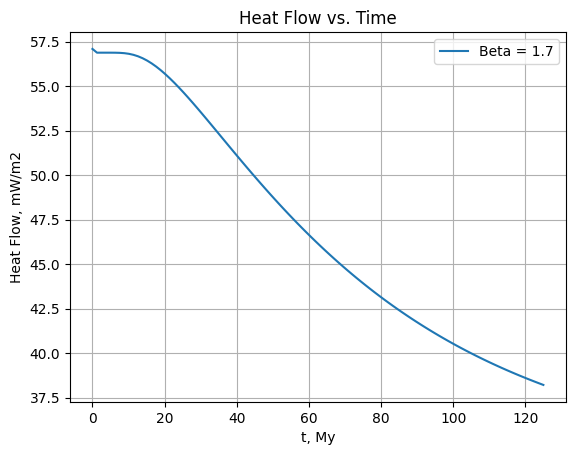

In [ ]:
import numpy as np
import sympy as sp
import matplotlib.pyplot as plt

def heat_flux(beta, t):

    # Define the variables and parameters
    a = 125
    tau = 62.8
    lam = 3.5
    T1 = 1333
    N = 100  # Number of terms in the sum

    # Define the equation for T/Tm with z as a variable
    T_sum = 0
    for n in range(1, N+1):
        Cn = beta / (n * np.pi) * np.sin(n * np.pi / beta) * np.exp(-n**2 * t / tau)
        T_sum += Cn
    T_over_Tm = 0.8 * (1 + 2 * T_sum) # 0.8 = 34.5 mW/m2

    return T_over_Tm * 10**-3 * 60 * 697


# beta_list = [1, 1.25, 1.5, 2, 4]
beta_list = [1.7]
t = np.linspace(0, 125, 100)

plt.figure()
for beta in beta_list:
    plt.plot(t, heat_flux(beta, t), label=f'Beta = {beta}')

plt.xlabel('t, My')
plt.ylabel('Heat Flow, mW/m2')
plt.title('Heat Flow vs. Time')
plt.grid(True)
plt.legend()
# plt.ylim(0, 140)
plt.show()

#### Temperature calculation (variable Heat Flow (F) for diffrent age)

In [ ]:
# import numpy as np
# import sympy as sp
# import matplotlib.pyplot as plt


def heat_flow_fundament_calculation(beta, t, Q_const, constant=False):

  ###
  # concstant = True: постоянный тепловой поток Q_const
  # Q_const: значение постоянного теплового потока, mW/m2

  ###

  if constant == True:
    return Q_const

  else:

    def tau_heat_flux(a, k):
      tau = a**2/(k * np.pi**2) # [second]
      # convert second to yaers, than to Million years
      seconds = tau
      years = seconds / 60 / 60 / 24 / 365.25  # Considering leap years
      return years * 10**-6 # [Myr]


    def heat_flux(beta, t):

        # Define the variables and parameters of lithosphere
        a = 125 * 1000 #m an initial lithosphere thickness
        k = 10**-6 #m2 s-1 thermal diffusivity of lithospheric rocks

        tau = tau_heat_flux(a, k)  # Myr Lithospheric time constant
        # tau = 62.8
        lam = 3.5 # Lithospheric thermal conductivity [W/mK]

        T1 = 1333
        N = 100 # Number of terms in the sum

        # Define the equation for F with z as a variable
        F_sum = 0
        for n in range(1, N+1):
            Cn = beta / (n * np.pi) * np.sin(n * np.pi / beta) * np.exp(-n**2 * t / tau)
            F_sum += Cn
        F_over_Tm = (lam*T1/a) * (1 + 2 * F_sum) # [mW/m2]
        return F_over_Tm

    return heat_flux(beta, t)

[0.0, 45.0, 47.0, 49.0, 51.0, 53.0, 55.0, 80.0, 82.0, 84.0, 86.0, 88.0, 90.0, 92.0, 94.0, 96.0, 98.0, 100.0, 125.0, 145.0, 160.0, 210.0, 245.0]
0.0 63.685954533544326
45.0 52.870550930991655
47.0 52.295536042771964
49.0 51.7380772163573
51.0 51.1982472399421
53.0 50.67599395824269
55.0 50.17116620969431
80.0 45.191873652900995
82.0 44.886331447088985
84.0 44.59244212214685
86.0 44.309792849941374
88.0 44.037980638132716
90.0 43.776612880082794
92.0 43.5253077437791
94.0 43.283694427161535
96.0 43.051413302898325
98.0 42.828115972017066
100.0 42.61346524273573
125.0 40.53928690306466


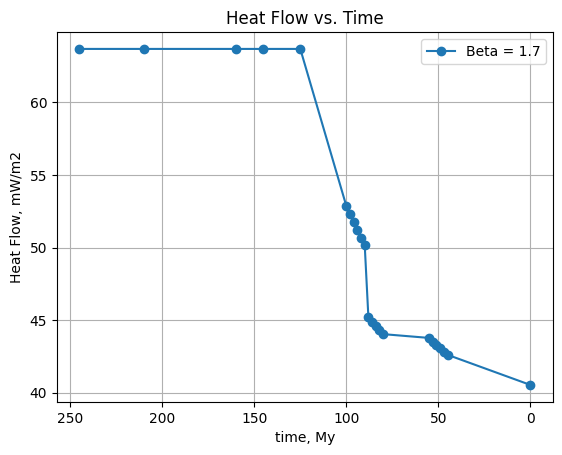

Age 0.0
0 Shales 200.0 200.0 0.04053928690306466
1 Sandstones 250.0 50.0 0.04053928690306466
2 Sandstones 300.0 50.0 0.04053928690306466
3 Sandstones 350.0 50.0 0.04053928690306466
4 Sandstones 400.0 50.0 0.04053928690306466
5 Sandstones 450.0 50.0 0.04053928690306466
6 Shales 1200.0 750.0 0.04053928690306466
7 Chalk 1330.0 130.0 0.04053928690306466
8 Chalk 1460.0 130.0 0.04053928690306466
9 Chalk 1590.0 130.0 0.04053928690306466
10 Chalk 1720.0 130.0 0.04053928690306466
11 Chalk 1850.0 130.0 0.04053928690306466
12 Chalk 1980.0 130.0 0.04053928690306466
13 Chalk 2110.0 130.0 0.04053928690306466
14 Chalk 2240.0 130.0 0.04053928690306466
15 Chalk 2370.0 130.0 0.04053928690306466
16 Chalk 2500.0 130.0 0.04053928690306466
17 Sandstones 3400.0 900.0 0.04053928690306466
18 Limestones 3600.0 200.0 0.04053928690306466
19 Dolomite 4000.0 400.0 0.04053928690306466
20 Sandstones 4250.0 250.0 0.04053928690306466
21 Anhydrite 5000.0 750.0 0.04053928690306466
22 Quartzite 5400.0 400.0 0.040539286903

In [ ]:
T_with_rad_heat = pd.DataFrame()
T_without_rad_heat = pd.DataFrame()
T_linear_geotherm =  pd.DataFrame()
age_list = list(work_layers['Age (Ma)'][0:])

# Heat flow
heat_flow = []

# print(age_list)

beta = 1.7
Qm_array = []
print(age_list)
for t in age_list:
  if t <= 125:
    Qm_array.append(heat_flow_fundament_calculation(beta, t, Q_const=63*10**-3,
                                                    constant=False))
    print(t, heat_flow_fundament_calculation(beta, t, Q_const=63*10**-3, constant=False)*10**3)
  else:
    Qm_array.insert(0, heat_flow_fundament_calculation(beta, 0, Q_const=63*10**-3,
                                                       constant=False))
# print(Qm_array)
Qm_array = Qm_array[::-1]
plt.plot(age_list, [x * 10**3 for x in Qm_array], label=f'Beta = {beta}', marker='o')

plt.xlabel('time, My')
plt.ylabel('Heat Flow, mW/m2')
plt.title('Heat Flow vs. Time')
plt.grid(True)
plt.legend()
plt.gca().invert_xaxis()
# plt.ylim(0, 140)
plt.show()
#  beta = stretch_factor_df[str(age)].iloc[0]

# Calculation for each age
for i, age in enumerate(age_list, start=0):

    work_layers_copy = work_layers.copy()

    T_list = []
    T_list_constant = []
    T_linear_geotherm_values = []

    T0 = 0
    G = 20

    print('Age', age)

    sum_variables_1, sum_variables_2 = [], []
    sum_variables_3, sum_variables_4 = [], []
    sum_variables_5 = []
    layers_sum = []
    heat_flow_list = []


### расчет для слоев с заданной литологией (work_layers)
    for row_index, row in enumerate(work_layers_copy[i::].itertuples(), start=i):

      lithology = work_layers_copy.at[row.Index, 'Lithology_type']
      layers_name = work_layers_copy.at[row.Index, 'Event_name']

      A = df_constast.loc[df_constast['Lithology_type'] == str(lithology), 'Radiogenic Heat Production'].iloc[0]
      K = tc_bulk_df.loc[row_index:].loc[tc_bulk_df['Lithology_type'] == str(lithology), f'{age}'].iloc[0]
      thickness_layer = decompaction_df.loc[row_index:].loc[decompaction_df['Lithology_type'] == str(lithology), f'{age}'].iloc[0]*1000

      # K = tc.loc[row_index:].loc[tc['Lithology_type'] == str(lithology), f'{age}'].iloc[0] ### reference Table  A58.8

# ### Depth values
      depth = decompaction_corrected_df.loc[row_index:].loc[decompaction_corrected_df['Lithology_type'] == str(lithology), f'{age}'].iloc[0]*1000
# ### Initial depth values
      y1 = work_layers.loc[work_layers['Event_name'] == str(layers_name), 'Depth top, m'].iloc[0]
      y2 = work_layers.loc[work_layers['Event_name'] == str(layers_name), 'Depth bottom, m'].iloc[0]

      layers_sum.append(thickness_layer)
      crust_depth = sum(layers_sum)
      Qm = Qm_array[i]


### With radio heat
      if K == 0:
        sum_variables_1.append(0)
        sum_variables_2.append(0)
      else:
        sum_variables_1.append(((Qm+A*crust_depth)/K)*thickness_layer)
        sum_variables_2.append((A/(2*K))*(thickness_layer)**2)


      T = T0 + (sum(sum_variables_1) - sum(sum_variables_2))
      T_list.append(T)
      heat_flow_list.append(Qm)

      print(row_index, lithology, crust_depth, thickness_layer, Qm )

### without radio heat
      # Qm = 63*10**-3
      A = 0

      if K == 0:
        sum_variables_3.append(0)
      else:
        sum_variables_3.append(((Qm+A*crust_depth)/K)*thickness_layer)
        sum_variables_4.append((A/(2*K))*(thickness_layer)**2)

      T_no_heat = T0 + (sum(sum_variables_3) - sum(sum_variables_4))
      T_list_constant.append(T_no_heat)

      # print(row_index, lithology, crust_depth, thickness_layer, Qm )

# ### Linear teady-stage geotherm Appendix 12
      T_linear_geotherm_values.append(linear_geotherm(G, depth/1000))

### Save results in table

### with radio heat
    new_col_name = f'{age}'
    ### Save result for decompaction in table
    resized_list_new = np.zeros(work_layers_copy.shape[0])
    resized_list_new[len(resized_list_new) - len(T_list):] = T_list
    new_col_values = resized_list_new
    T_with_rad_heat[new_col_name] = new_col_values

### without radio heat
    resized_list_new = np.zeros(work_layers_copy.shape[0])
    resized_list_new[len(resized_list_new) - len(T_list_constant):] = T_list_constant
    new_col_values = resized_list_new
    T_without_rad_heat[new_col_name] = new_col_values


### Linear teady-stage geotherm Appendix 12
    resized_list_new = np.zeros(work_layers_copy.shape[0])
    resized_list_new[len(resized_list_new) - len(T_list_constant):] = T_linear_geotherm_values
    new_col_values = resized_list_new
    T_linear_geotherm[new_col_name] = new_col_values


In [ ]:
save_to_csv(T_with_rad_heat, work_layers, "Geotherm_with_A")
save_to_csv(T_without_rad_heat, work_layers, "Geotherm_without_A")
save_to_csv(T_linear_geotherm, work_layers, "Linear_Geotherm")

In [ ]:
# ### добавление колонок Lithology_type,	Event_name
# work_layers.reset_index(drop=True, inplace=True)
# T_with_rad_heat['Event_name'] = work_layers['Event_name']
# T_with_rad_heat['Lithology_type'] = work_layers['Lithology_type']
# T_with_rad_heat = T_with_rad_heat[T_with_rad_heat.columns[::-1]]

# T_with_rad_heat.to_csv('/content/T_with_rad_heat.csv', index=True)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# ### добавление колонок Lithology_type,	Event_name
# work_layers.reset_index(drop=True, inplace=True)
# T_without_rad_heat['Event_name'] = work_layers['Event_name']
# T_without_rad_heat['Lithology_type'] = work_layers['Lithology_type']
# T_without_rad_heat = T_without_rad_heat[T_without_rad_heat.columns[::-1]]

# T_without_rad_heat.to_csv('/content/T_without_rad_heat.csv', index=True)

In [ ]:
tc_bulk_df

,Lithology_type,Event_name,245.0,210.0,160.0,145.0,125.0,100.0,98.0,96.0,...,84.0,82.0,80.0,55.0,53.0,51.0,49.0,47.0,45.0,0.0
0,Shales,Layer 10,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.1614
1,Sandstones,Layer 9_1,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,3.1137,3.2411
2,Sandstones,Layer 9_2,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,3.1137,3.1480,3.2705
3,Sandstones,Layer 9_3,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,3.1186,3.1480,3.1823,3.2999
4,Sandstones,Layer 9_4,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,3.1186,3.1529,3.1823,3.2166,3.3293
5,Sandstones,Layer 9_5,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,3.1186,3.1529,3.1823,3.2166,3.2460,3.3587
6,Shales,Layer 8,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,1.2902,1.3070,1.3224,1.3378,1.3518,1.3658,1.4176
7,Chalk,Layer 7_1,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,1.5720,2.3442,2.3658,2.3874,2.4090,2.4306,2.4522,2.5305
8,Chalk,Layer 7_2,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,1.5774,1.8366,2.4360,2.4549,2.4738,2.4927,2.5116,2.5305,2.5980
9,Chalk,Layer 7_3,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,1.5828,1.8474,2.0310,2.5170,2.5332,2.5521,2.5683,2.5845,2.6007,2.6601


In [ ]:
T_with_rad_heat

,0.0,45.0,47.0,49.0,51.0,53.0,55.0,80.0,82.0,84.0,...,96.0,98.0,100.0,125.0,145.0,160.0,210.0,245.0,Event_name,Lithology_type
0,7.010382,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,Layer 10,Shales
1,7.639941,0.712182,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,Layer 9_1,Sandstones
2,8.264758,1.417636,0.729542,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,Layer 9_2,Sandstones
3,8.884918,2.116505,1.452206,0.746016,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,Layer 9_3,Sandstones
4,9.500502,2.808931,2.168140,1.485026,0.750038,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,Layer 9_4,Sandstones
5,10.111591,3.496085,2.877488,2.204719,1.493027,0.768199,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,Layer 9_5,Sandstones
6,32.301447,29.113578,29.333496,29.555703,29.829010,30.191644,30.649430,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,Layer 8,Shales
7,34.410077,31.484389,31.772188,32.064282,32.391284,32.827960,33.362137,7.236076,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,Layer 7_1,Chalk
8,36.466523,33.784722,34.117962,34.456778,34.849541,35.336024,35.921531,12.288057,7.481017,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,Layer 7_2,Chalk
9,38.477503,36.009156,36.383638,36.764792,37.201054,37.734872,38.384119,16.363440,12.655168,7.700684,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,Layer 7_3,Chalk


In [ ]:
T_with_rad_heat_test

NameError: name 'T_with_rad_heat_test' is not defined

In [ ]:
df_constast

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Lithology_type,Porosity,"Exp_decay, km-1",Grain density,TC matrix,Radiogenic Heat Production,Ki_framework
0,Shales,0.63,0.51,2720,2.0,1.700000e-06,2.0
1,Sandstones,0.49,0.27,2650,5.5,1.200000e-06,5.5
2,Chalk,0.70,0.71,2710,3.3,4.000000e-07,3.3
3,Limestones,0.40,0.60,2710,3.3,5.000000e-07,3.3
4,Dolomite,0.20,0.60,2870,5.3,4.000000e-07,5.3
5,Anhydrite,0.05,0.20,2960,6.3,1.000000e-07,6.3
6,Quartzite,0.20,0.30,2650,7.7,5.000000e-07,7.7
7,Fundament,0.00,0.00,2800,3.0,2.800000e-06,3.0


###Sekiguchi–Waples Model

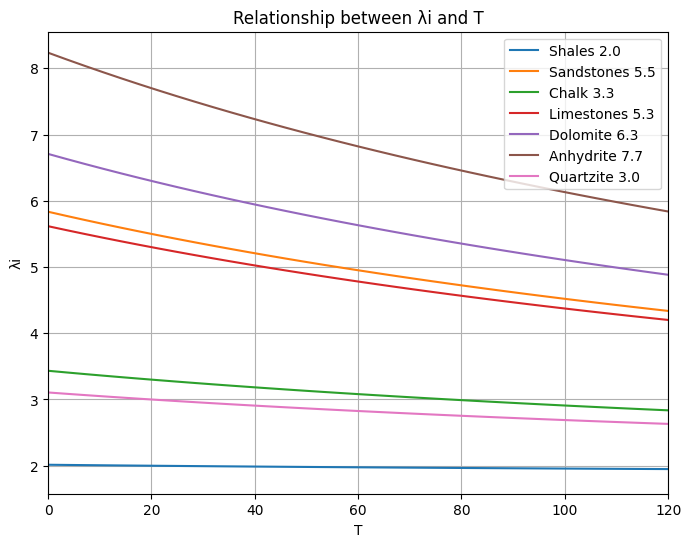

In [ ]:
def Sekiguchi_Waples(T, lambda_m, correction=True):
  ###
  # return thermal conductivity depending from tempreture
  ###
  if correction == True:
    return 358 * (1.0227 * lambda_m - 1.882) * (T**(-1) - 0.00068) + 1.84
  else:
    pass




# Get the unique values from the "TC matrix" column
lam_20_range = df_constast["TC matrix"].unique()
label_range = df_constast["Lithology_type"]

fig, ax = plt.subplots(figsize=(8, 6))

for lam_20, lit in zip(lam_20_range,label_range):

  T_range = np.linspace(0, 350, 100)

  lambda_m = lam_20
  lambda_i_values = [Sekiguchi_Waples(T+273.15, lambda_m, correction=True) for T in T_range]

  ax.plot(T_range, lambda_i_values, label=f'{lit} {lam_20}')

ax.set_xlabel('T')
ax.set_ylabel('λi')
ax.set_title('Relationship between λi and T')
ax.grid(True)
ax.legend()
plt.xlim(0, 120)
plt.show()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


0.0 63.685954533544326
45.0 52.870550930991655
47.0 52.295536042771964
49.0 51.7380772163573
51.0 51.1982472399421
53.0 50.67599395824269
55.0 50.17116620969431
80.0 45.191873652900995
82.0 44.886331447088985
84.0 44.59244212214685
86.0 44.309792849941374
88.0 44.037980638132716
90.0 43.776612880082794
92.0 43.5253077437791
94.0 43.283694427161535
96.0 43.051413302898325
98.0 42.828115972017066
100.0 42.61346524273573
125.0 40.53928690306466
145.0 39.482373097884626


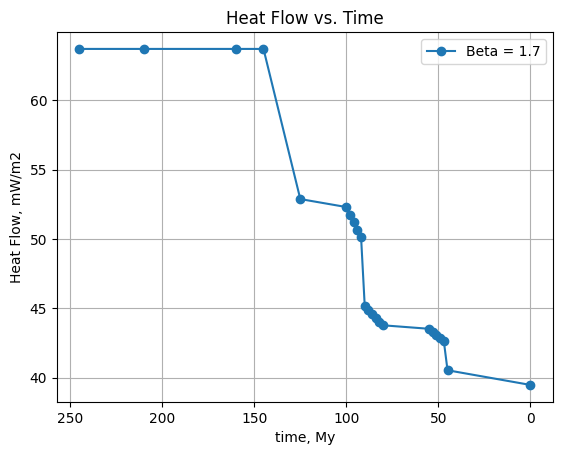

Age 0.0
0 Shales 0.599 8.133534332878806 0.975154151826328 1.1614 2.0
1 Sandstones 0.461 9.118671723102644 2.0176055386981244 3.2411 5.5
2 Sandstones 0.455 10.093619121378905 2.0417703133663503 3.2704999999999997 5.5
3 Sandstones 0.449 11.05849131472802 2.06619971912994 3.2998999999999996 5.5
4 Sandstones 0.443 12.013401410706095 2.090896999941315 3.3292999999999995 5.5
5 Sandstones 0.437 12.958460874427637 2.1158654366783978 3.3587 5.5
6 Shales 0.416 38.223424643377236 1.2136829129792304 1.4176000000000002 2.0
7 Chalk 0.285 40.84521933704743 1.9827977054327417 2.5305 3.3
8 Chalk 0.26 43.37136002468478 2.0605536849942347 2.598 3.3
9 Chalk 0.237 45.813587436332135 2.13412087583169 2.6601 3.3
10 Chalk 0.216 48.18264536176064 2.2028876739183305 2.7168 3.3
11 Chalk 0.197 50.48842891600559 2.2662701766194897 2.7680999999999996 3.3
12 Chalk 0.18 52.74011447359161 2.323720772244243 2.814 3.3
13 Chalk 0.164 54.942642749285525 2.3786520974739473 2.8571999999999997 3.3
14 Chalk 0.149 57.10066798

In [ ]:
T_with_rad_heat_test = pd.DataFrame()
T_without_rad_heat_test = pd.DataFrame()
T_linear_geotherm_test =  pd.DataFrame()
# age_list = list(df_well['Age (Ma)'][1:])

# Heat flow
heat_flow = []

# print(age_list)

beta = 1.7
Qm_array = []
for t in age_list:
  if t <= 145:
    Qm_array.append(heat_flow_fundament_calculation(beta, t, Q_const=63*10**-3,
                                                    constant=False))
    print(t, heat_flow_fundament_calculation(beta, t, Q_const=63*10**-3, constant=False)*10**3)
  else:
    Qm_array.insert(0, heat_flow_fundament_calculation(beta, 0, Q_const=63*10**-3,
                                                       constant=False))
# print(Qm_array)
Qm_array = Qm_array[::-1]
plt.plot(age_list, [x * 10**3 for x in Qm_array], label=f'Beta = {beta}', marker='o')

plt.xlabel('time, My')
plt.ylabel('Heat Flow, mW/m2')
plt.title('Heat Flow vs. Time')
plt.grid(True)
plt.legend()
plt.gca().invert_xaxis()
# plt.ylim(0, 140)
plt.show()
#  beta = stretch_factor_df[str(age)].iloc[0]

# Calculation for each age
for i, age in enumerate(age_list, start=0):

    work_layers_copy = work_layers.copy()

    T_list = []
    T_list_constant = []
    T_linear_geotherm_values = []

    T0 = 0
    G = 20

    print('Age', age)

    sum_variables_1, sum_variables_2 = [], []
    sum_variables_3, sum_variables_4 = [], []
    sum_variables_5 = []
    layers_sum = []
    heat_flow_list = []


### расчет для слоев с заданной литологией (work_layers)
    for row_index, row in enumerate(work_layers_copy[i::].itertuples(), start=i):

      lithology = work_layers_copy.at[row.Index, 'Lithology_type']
      layers_name = work_layers_copy.at[row.Index, 'Event_name']

      A = df_constast.loc[df_constast['Lithology_type'] == str(lithology), 'Radiogenic Heat Production'].iloc[0]
      K_20= tc_bulk_df.loc[row_index:].loc[tc_bulk_df['Lithology_type'] == str(lithology), f'{age}'].iloc[0]
      thickness_layer = decompaction_df.loc[row_index:].loc[decompaction_df['Lithology_type'] == str(lithology), f'{age}'].iloc[0]*1000

### Sekiguchi_Waples
      tc_matrix = df_constast.loc[df_constast['Lithology_type'] == str(lithology), 'TC matrix'].iloc[0]
      phi0 = porosity_df.loc[(porosity_df['Lithology_type'] == str(lithology)) & (porosity_df['Event_name'] == layers_name), f'{age}'].iloc[0]
      tc_water = 0.60

      if row_index == i:
        T_sg = T0
        if T0 == 0:
          T0 = 10**-3

        K_mtrx_corrected_SG = Sekiguchi_Waples(T_sg+273.15, tc_matrix, correction=True)
        # K = bulk_thermal_conductivity(K_mtrx_corrected_SG, tc_water, phi0)
        K = bulk_thermal_conductivity_geomean(K_mtrx_corrected_SG, tc_water, phi0)
      else:
        T_sg = T_list[-1]
        K_mtrx_corrected_SG = Sekiguchi_Waples(T_sg+273.15, tc_matrix, correction=True)
        # print(T_sg, lithology, tc_matrix, K_mtrx_corrected_SG)
        # K = bulk_thermal_conductivity(K_mtrx_corrected_SG, tc_water, phi0) # Arithmetic mean
        K = bulk_thermal_conductivity_geomean(K_mtrx_corrected_SG, tc_water, phi0) # Geometric mean


# ### Depth values
      depth = decompaction_corrected_df.loc[row_index:].loc[decompaction_corrected_df['Lithology_type'] == str(lithology), f'{age}'].iloc[0]*1000
# ### Initial depth values
      y1 = work_layers.loc[work_layers['Event_name'] == str(layers_name), 'Depth top, m'].iloc[0]
      y2 = work_layers.loc[work_layers['Event_name'] == str(layers_name), 'Depth bottom, m'].iloc[0]

      layers_sum.append(thickness_layer)
      crust_depth = sum(layers_sum)
      Qm = Qm_array[i]


### With radio heat
      if K == 0:
        sum_variables_1.append(0)
        sum_variables_2.append(0)
      else:
        sum_variables_1.append(((Qm+A*crust_depth)/K)*thickness_layer)
        sum_variables_2.append((A/(2*K))*(thickness_layer)**2)


      T = T0 + (sum(sum_variables_1) - sum(sum_variables_2))
      T_list.append(T)
      # heat_flow_list.append(Qm)

      # print(row_index, lithology, crust_depth, thickness_layer, K, Qm, T, phi0)
      print(row_index, lithology, phi0, T, K, K_20, tc_matrix)

### without radio heat
      # Qm = 63*10**-3
      A = 0

      if K == 0:
        sum_variables_3.append(0)
      else:
        sum_variables_3.append(((Qm+A*crust_depth)/K)*thickness_layer)
        sum_variables_4.append((A/(2*K))*(thickness_layer)**2)

      T_no_heat = T0 + (sum(sum_variables_3) - sum(sum_variables_4))
      T_list_constant.append(T_no_heat)

      # print(row_index, lithology, crust_depth, thickness_layer, Qm )

# ### Linear teady-stage geotherm Appendix 12
      T_linear_geotherm_values.append(linear_geotherm(G, depth/1000))

# ### Save results in table

### with radio heat
    new_col_name = f'{age}'
    ### Save result for decompaction in table
    resized_list_new = np.zeros(work_layers_copy.shape[0])
    resized_list_new[len(resized_list_new) - len(T_list):] = T_list
    new_col_values = resized_list_new
    T_with_rad_heat_test[new_col_name] = new_col_values

### without radio heat
    resized_list_new = np.zeros(work_layers_copy.shape[0])
    resized_list_new[len(resized_list_new) - len(T_list_constant):] = T_list_constant
    new_col_values = resized_list_new
    T_without_rad_heat_test[new_col_name] = new_col_values


### Linear teady-stage geotherm Appendix 12
    resized_list_new = np.zeros(work_layers_copy.shape[0])
    resized_list_new[len(resized_list_new) - len(T_list_constant):] = T_linear_geotherm_values
    new_col_values = resized_list_new
    T_linear_geotherm_test[new_col_name] = new_col_values


In [ ]:
df_constast

,Lithology_type,Porosity,"Exp_decay, km-1",Grain density,TC matrix,Radiogenic Heat Production,Ki_framework
0,Shales,0.63,0.51,2720,2.0,1.700000e-06,2.0
1,Sandstones,0.49,0.27,2650,5.5,1.200000e-06,5.5
2,Chalk,0.70,0.71,2710,3.3,4.000000e-07,3.3
3,Limestones,0.40,0.60,2710,3.3,5.000000e-07,3.3
4,Dolomite,0.20,0.60,2870,5.3,4.000000e-07,5.3
5,Anhydrite,0.05,0.20,2960,6.3,1.000000e-07,6.3
6,Quartzite,0.20,0.30,2650,7.7,5.000000e-07,7.7
7,Fundament,0.00,0.00,2800,3.0,2.800000e-06,3.0


In [ ]:
save_to_csv(T_with_rad_heat_test, work_layers, "Geotherm_SG")

In [ ]:
T_without_rad_heat_test

,0.0,45.0,47.0,49.0,51.0,53.0,55.0,80.0,82.0,84.0,...,92.0,94.0,96.0,98.0,100.0,125.0,145.0,160.0,210.0,245.0
0,8.098668,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,9.077114,1.094870,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,10.043981,2.173346,1.172949,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,10.999415,3.236662,2.328550,1.198350,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,11.943564,4.285047,3.468049,2.379049,1.204593,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5,12.876572,5.321068,4.591690,3.524381,2.391460,1.233495,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6,37.274855,33.219716,34.826552,34.878371,34.977254,35.170390,35.457058,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7,39.863475,36.102415,37.949067,38.105480,38.288873,38.593647,38.996022,10.046977,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
8,42.354411,38.858130,40.908201,41.137077,41.417680,41.800247,42.283140,17.003934,10.384033,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
9,44.759481,41.486291,43.726589,44.019995,44.367133,44.823546,45.399997,22.515370,17.502119,10.685704,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [ ]:
T_with_rad_heat_test

,0.0,45.0,47.0,49.0,51.0,53.0,55.0,80.0,82.0,84.0,...,96.0,98.0,100.0,125.0,145.0,160.0,210.0,245.0,Event_name,Lithology_type
0,8.133534,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,Layer 10,Shales
1,9.118672,1.095712,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,Layer 9_1,Sandstones
2,10.093619,2.176678,1.173824,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,Layer 9_2,Sandstones
3,11.058491,3.244085,2.332012,1.199256,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,Layer 9_3,Sandstones
4,12.013401,4.298119,3.475763,2.382634,1.205498,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,Layer 9_4,Sandstones
5,12.958461,5.341316,4.605273,3.532283,2.395045,1.234435,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,Layer 9_5,Sandstones
6,38.223425,34.012111,35.587360,35.603757,35.665383,35.822450,36.071924,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,Layer 8,Shales
7,40.845219,36.926880,38.741984,38.862859,39.008572,39.277121,39.642111,10.058818,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,Layer 7_1,Chalk
8,43.371360,39.716923,41.735339,41.928419,42.171260,42.517325,42.962534,17.038851,10.396577,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,Layer 7_2,Chalk
9,45.813587,42.381311,44.589904,44.847310,45.156435,45.576191,46.114995,22.578563,17.538810,10.698870,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,Layer 7_3,Chalk


In [ ]:
T_with_rad_heat

,0.0,45.0,47.0,49.0,51.0,53.0,55.0,80.0,82.0,84.0,...,96.0,98.0,100.0,125.0,145.0,160.0,210.0,245.0,Event_name,Lithology_type
0,7.010382,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,Layer 10,Shales
1,7.639941,0.712182,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,Layer 9_1,Sandstones
2,8.264758,1.417636,0.729542,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,Layer 9_2,Sandstones
3,8.884918,2.116505,1.452206,0.746016,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,Layer 9_3,Sandstones
4,9.500502,2.808931,2.168140,1.485026,0.750038,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,Layer 9_4,Sandstones
5,10.111591,3.496085,2.877488,2.204719,1.493027,0.768199,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,Layer 9_5,Sandstones
6,32.301447,29.113578,29.333496,29.555703,29.829010,30.191644,30.649430,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,Layer 8,Shales
7,34.410077,31.484389,31.772188,32.064282,32.391284,32.827960,33.362137,7.236076,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,Layer 7_1,Chalk
8,36.466523,33.784722,34.117962,34.456778,34.849541,35.336024,35.921531,12.288057,7.481017,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,Layer 7_2,Chalk
9,38.477503,36.009156,36.383638,36.764792,37.201054,37.734872,38.384119,16.363440,12.655168,7.700684,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,Layer 7_3,Chalk


In [ ]:
T0 = 0
Linear = T_linear_geotherm_test["0.0"].tolist()
Linear.insert(0, T0)


A_line = T_without_rad_heat_test["0.0"].tolist()
A_line.insert(0, T0)

C_line = T_with_rad_heat_test["0.0"].tolist()
C_line.insert(0, T0)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[0, 9.999999999999986, 10.99999999999997, 11.99999999999995, 12.999999999999956, 13.999999999999952, 14.999999999999948, 29.99999999999996, 32.599999999999966, 35.19999999999997, 37.799999999999955, 40.399999999999956, 42.99999999999997, 45.59999999999998, 48.19999999999996, 50.799999999999976, 53.39999999999998, 55.99999999999998, 73.99999999999997, 77.99999999999997, 85.99999999999997, 90.99999999999994, 105.99999999999993, 113.99999999999993] [0, 0.2, 0.25, 0.30000000000000004, 0.35000000000000003, 0.4, 0.45, 1.2, 1.33, 1.46, 1.5899999999999999, 1.72, 1.85, 1.98, 2.11, 2.24, 2.37, 2.5, 3.4, 3.6, 4.0, 4.25, 5.0, 5.4]


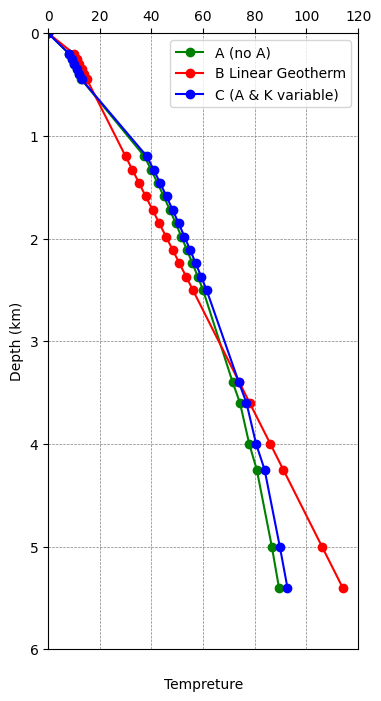

In [ ]:
y = work_layers["Depth bottom, m"].tolist()
y_add = y.insert(0, 0)

print(Linear, y)

plt.figure(figsize=(4, 8))
plt.plot(A_line, y , label='A (no A)', marker='o', color='green')
# plt.plot(T_true['0'], y , label='McKenzie')
plt.plot(Linear, y , label='B Linear Geotherm', marker='o', color='red')
plt.plot(C_line, y , label='C (A & K variable)', marker='o', color='blue')


# plt.axis([np.round(max(age_values), -2), np.min(age_values), np.max(output_df)+0.5, 0])

plt.tick_params(axis='x', which='both', bottom=False, top=True, labelbottom=False, labeltop=True)
# plt.tick_params(axis='y', which='both', left=False, right=True, labelleft=False, labelright=True)

# Move the x-axis label to the top
plt.xlabel(f'Tempreture', labelpad=20)
plt.ylabel(f'Depth (km)')
# plt.gca().xaxis.set_label_coords(0.5, 1.15)

plt.legend()
plt.grid(color='gray', linestyle='--', linewidth=0.5)

plt.xlim(0, 120)
plt.ylim(0, 6)
plt.gca().invert_yaxis()
plt.show()

#### Plot: Geotherm

In [ ]:
T0 = 0
Linear = T_linear_geotherm["0.0"].tolist()
Linear.insert(0, T0)


A_line = T_without_rad_heat["0.0"].tolist()
A_line.insert(0, T0)

C_line = T_with_rad_heat["0.0"].tolist()
C_line.insert(0, T0)

[0, 9.999999999999986, 10.99999999999997, 11.99999999999995, 12.999999999999956, 13.999999999999952, 14.999999999999948, 29.99999999999996, 32.599999999999966, 35.19999999999997, 37.799999999999955, 40.399999999999956, 42.99999999999997, 45.59999999999998, 48.19999999999996, 50.799999999999976, 53.39999999999998, 55.99999999999998, 73.99999999999997, 77.99999999999997, 85.99999999999997, 90.99999999999994, 105.99999999999993, 113.99999999999993] [0, 0.2, 0.25, 0.30000000000000004, 0.35000000000000003, 0.4, 0.45, 1.2, 1.33, 1.46, 1.5899999999999999, 1.72, 1.85, 1.98, 2.11, 2.24, 2.37, 2.5, 3.4, 3.6, 4.0, 4.25, 5.0, 5.4]


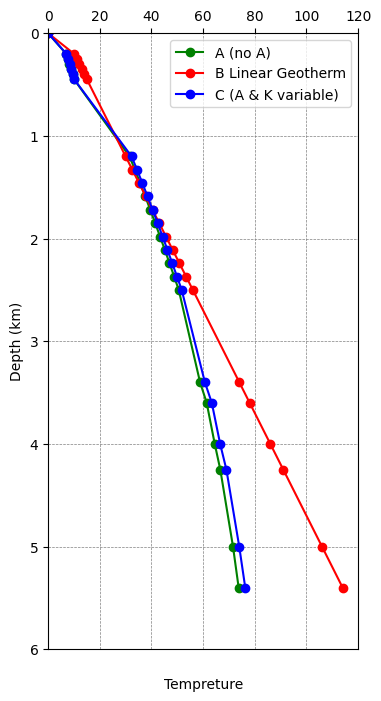

In [ ]:
y = work_layers["Depth bottom, m"].tolist()
y_add = y.insert(0, 0)

print(Linear, y)

plt.figure(figsize=(4, 8))
plt.plot(A_line, y , label='A (no A)', marker='o', color='green')
# plt.plot(T_true['0'], y , label='McKenzie')
plt.plot(Linear, y , label='B Linear Geotherm', marker='o', color='red')
plt.plot(C_line, y , label='C (A & K variable)', marker='o', color='blue')


# plt.axis([np.round(max(age_values), -2), np.min(age_values), np.max(output_df)+0.5, 0])

plt.tick_params(axis='x', which='both', bottom=False, top=True, labelbottom=False, labeltop=True)
# plt.tick_params(axis='y', which='both', left=False, right=True, labelleft=False, labelright=True)

# Move the x-axis label to the top
plt.xlabel(f'Tempreture', labelpad=20)
plt.ylabel(f'Depth (km)')
# plt.gca().xaxis.set_label_coords(0.5, 1.15)

plt.legend()
plt.grid(color='gray', linestyle='--', linewidth=0.5)

plt.xlim(0, 120)
plt.ylim(0, 6)
plt.gca().invert_yaxis()
plt.show()

In [ ]:
def makeplot(data1, data2, top_depth, bottom_depth):
    # fig = plt.figure(constrained_layout=True, figsize=(10, 6))
    # ax = fig.subplots(1, 2,  sharex=False)

    fig, ax = plt.subplots(figsize=(14,7))

    ax1 = plt.subplot2grid((1,3), (0,0), rowspan=1, colspan = 1)
    ax2 = plt.subplot2grid((1,3), (0,1), rowspan=1, colspan = 1, sharey = ax1)
    ax3 = plt.subplot2grid((1,3), (0,2), rowspan=1, colspan = 1, sharey = ax1)

    # As our curve scales will be detached from the top of the track,
    # this code adds the top border back in without dealing with splines
    # ax10 = ax1.twiny()
    # ax10.xaxis.set_visible(False)

    # ax13 = ax4.twiny()
    # ax13.xaxis.set_visible(False)

### Plot 1
    # Geotherma
    T0 = 0

    x_values = data1['0.0'].tolist()
    x_values.insert(0, T0)
    y_values = decompaction_corrected_df['0.0'].tolist()
    y_values.insert(0, 0)
    ax1.plot(x_values, y_values, label='With radiation', marker='o', color='red')

    x_values = data2['0.0'].tolist()
    x_values.insert(0, T0)
    y_values = decompaction_corrected_df['0.0'].tolist()
    y_values.insert(0, 0)
    ax1.plot(x_values, y_values, label='Linear', marker='o', color='black')
    # ax1.plot(T_true['0'], decompaction_corrected_df['0'], label='McKenzie')

    ax1.set_xlabel(f'Tempreture', labelpad=20)
    ax1.set_ylabel(f'Depth (km)')
    ax1.legend()
    ax1.set_xlim([0, 120])

### Plot 2
    # Lithology track
    # ax2.plot(T_with_rad_heat["Lithology"], T_with_rad_heat['depth 0'], color = "black", linewidth = 0.5)
    ax2.set_xlabel("Lithology")
    ax2.set_xlim(0, 1)
    ax2.xaxis.label.set_color("black")
    ax2.tick_params(axis='x', colors="black")
    ax2.spines["top"].set_edgecolor("black")
    ax2.set_xticks([0, 1])

    depth_start = 0

    for lit, depth in zip(pd_lithology["Lithology"], decompaction_corrected_df['0.0']):
        key = int(lit)
        color = lithology_numbers[key]['color']
        hatch = lithology_numbers[key]['hatch']

        depth_values = [depth_start, depth]
        depth_start = depth

        ax2.fill_betweenx(depth_values, 0, 1, facecolor=color, hatch=hatch)

    ax2.set_xticks([0, 1])

### Plot3
    ax3.set_xlabel("Lithology")
    ax3.set_xlim(0, 1)
    ax3.xaxis.label.set_color("black")
    ax3.tick_params(axis='x', colors="black")
    ax3.spines["top"].set_edgecolor("black")
    ax3.set_xticks([0, 1])

    depth_start = 0

    for lit, depth in zip(pd_lithology["Lithology_type"], decompaction_corrected_df['0.0']):
        key = lit
        depth_values = [depth_start, depth]
        depth_start = depth

        label_position = (0.5, sum(depth_values) / 2)  # Assuming x position is at 0.5
        ax3.text(label_position[0], label_position[1], key, ha='center', va='center')
        ax3.plot([0, 1], [depth, depth], color='black', linewidth=1)  # Assuming black color and linewidth of 1



    for ax in [ax1, ax2, ax3]:
        ax.set_ylim(bottom_depth, top_depth)
        ax.grid(which='major', color='lightgrey', linestyle='-')
        ax.xaxis.set_ticks_position("top")
        ax.xaxis.set_label_position("top")
        ax.spines["top"].set_position(("axes", 1.02))

    for ax in [ax2]:
        plt.setp(ax.get_yticklabels(), visible = False)

    plt.tight_layout()
    fig.subplots_adjust(wspace = 0.15)

<ipython-input-150-5497e3f0cc4d>:7: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax1 = plt.subplot2grid((1,3), (0,0), rowspan=1, colspan = 1)


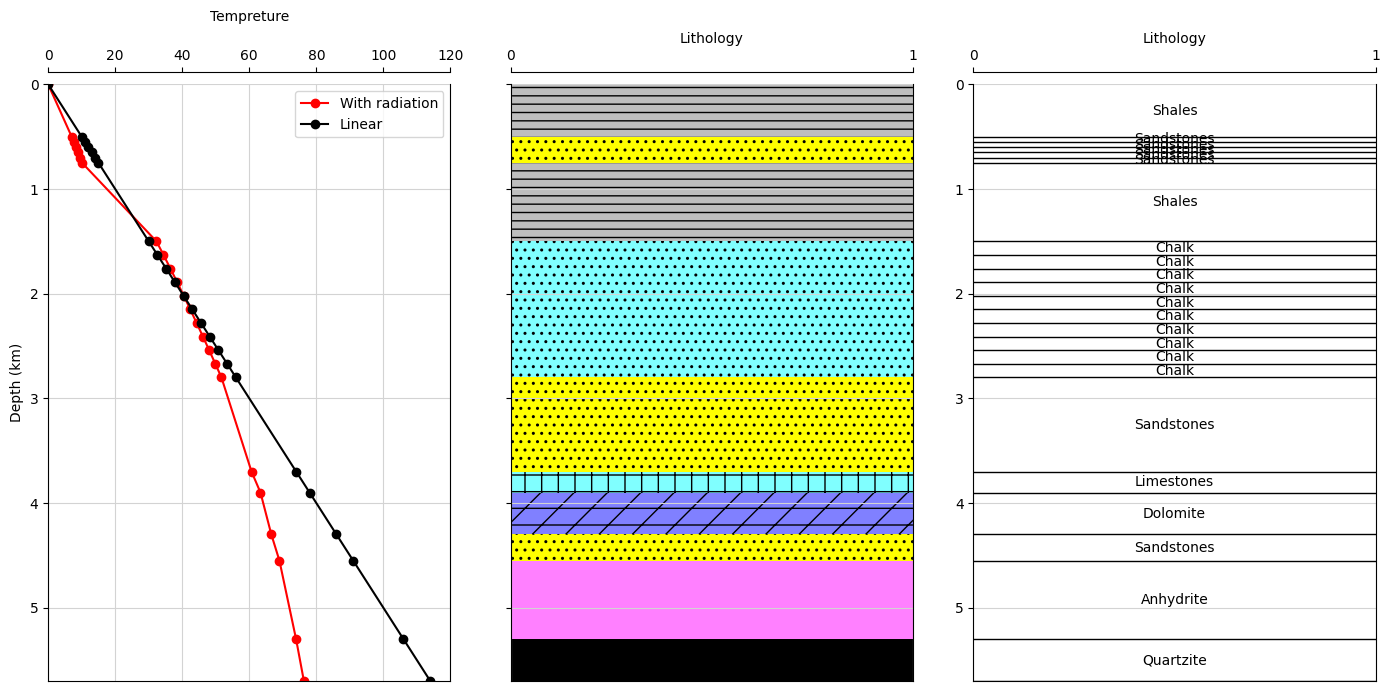

In [ ]:
temperature = pd.read_csv('/content/Geotherm_with_A', skiprows=0, header=0)
linear_temperature = pd.read_csv('/content/Linear_Geotherm', skiprows=0, header=0)

makeplot(temperature, # данные 1: геотерма с изменяюшимся ТС и Радиацией
         linear_temperature,  # данные 2: линейная геотерма
         0, max(decompaction_corrected_df['0.0']))

### Plot: Paleotemperature

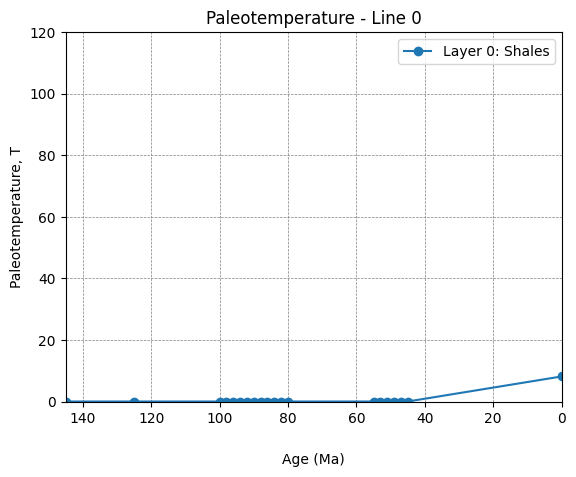

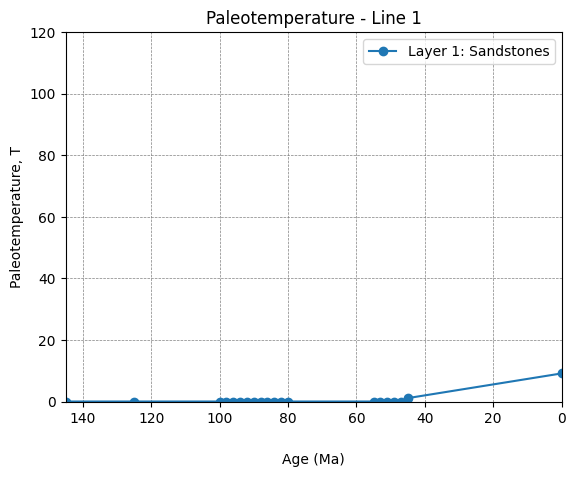

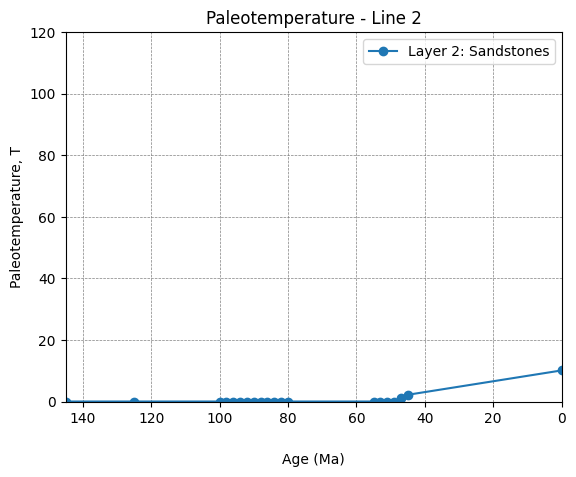

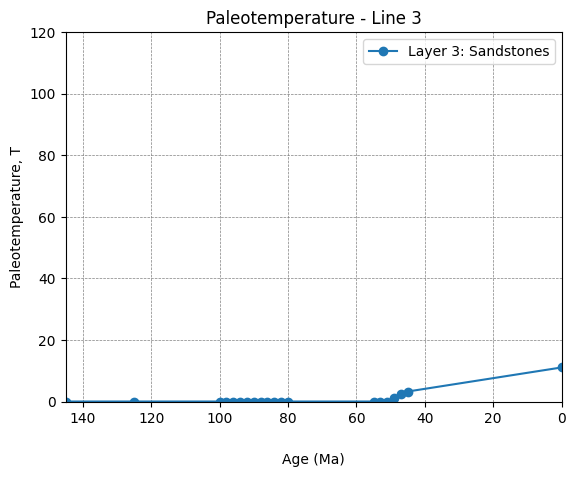

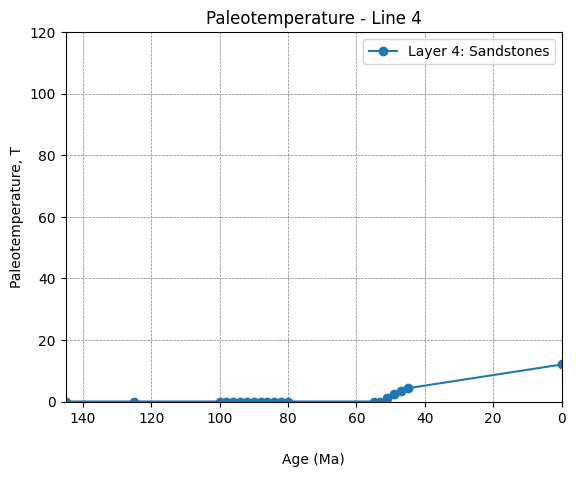

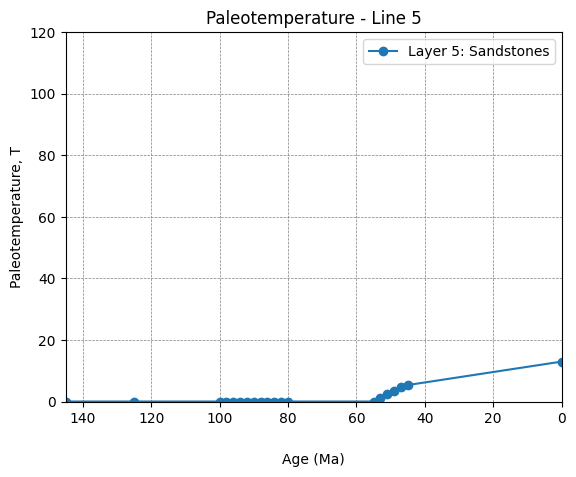

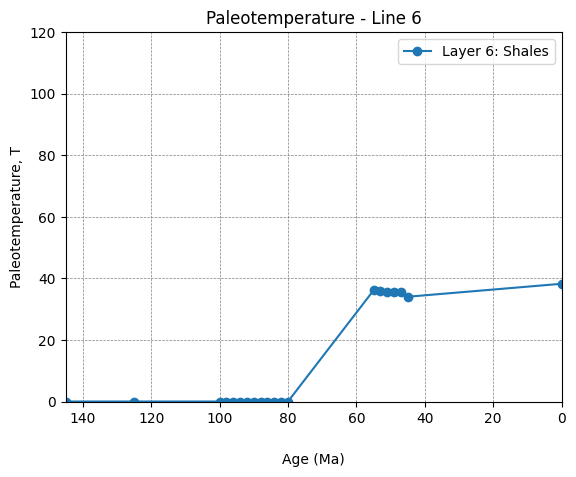

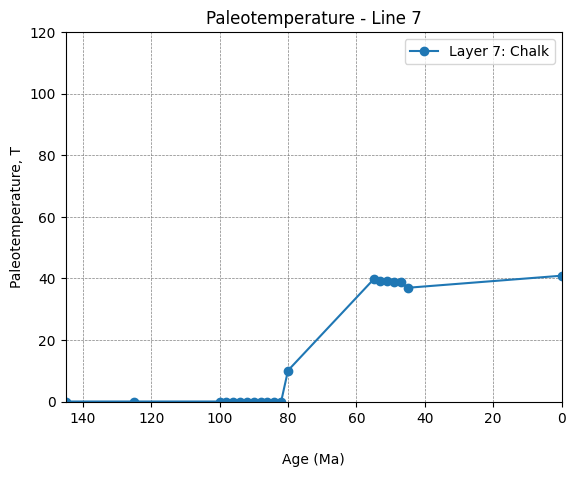

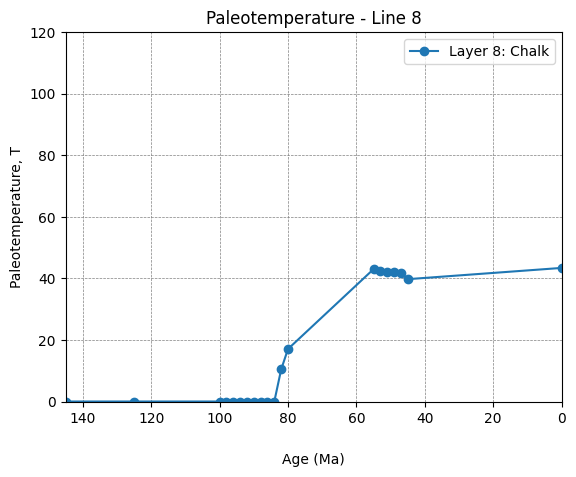

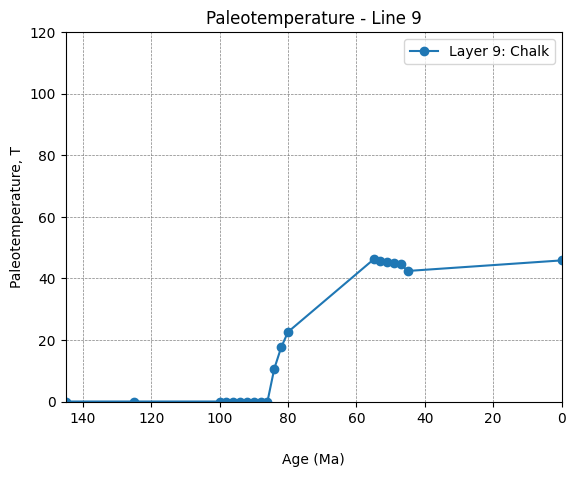

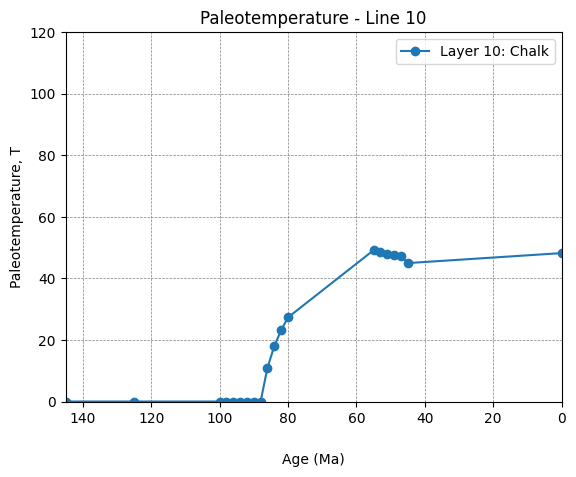

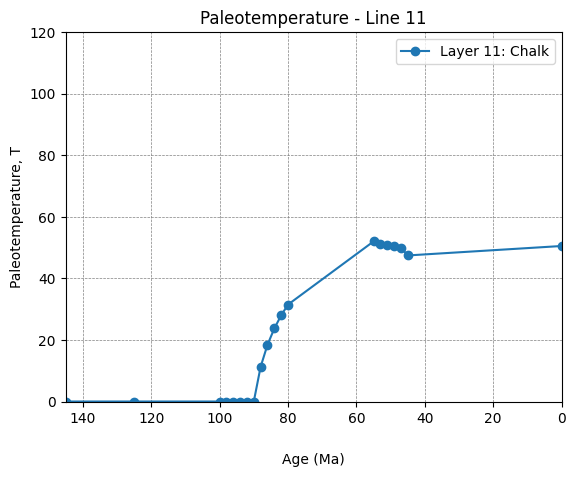

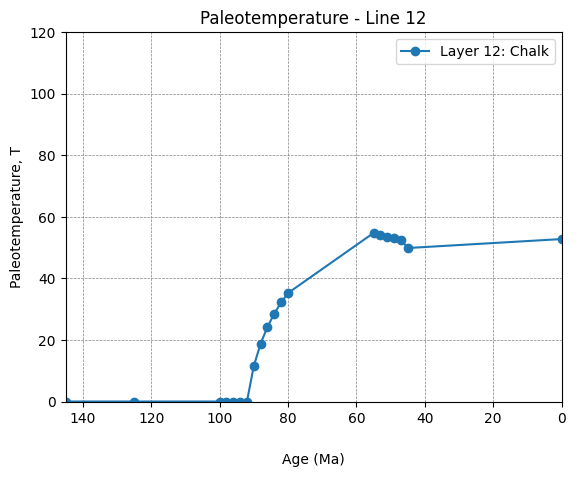

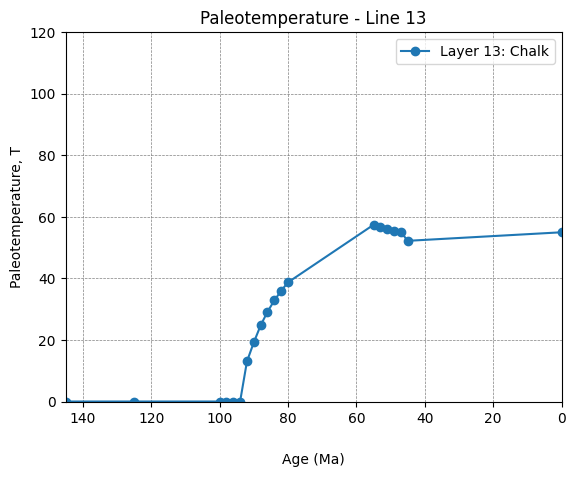

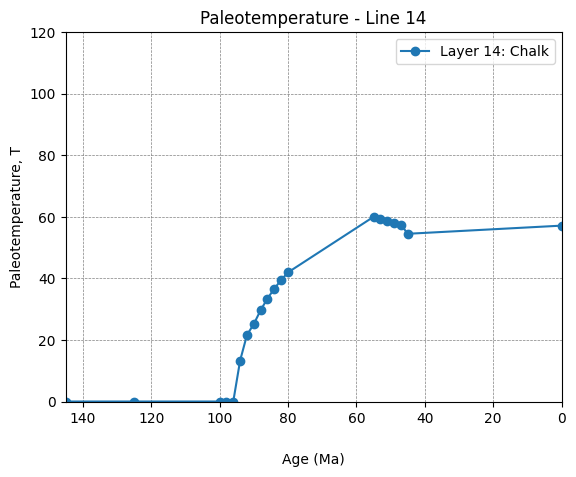

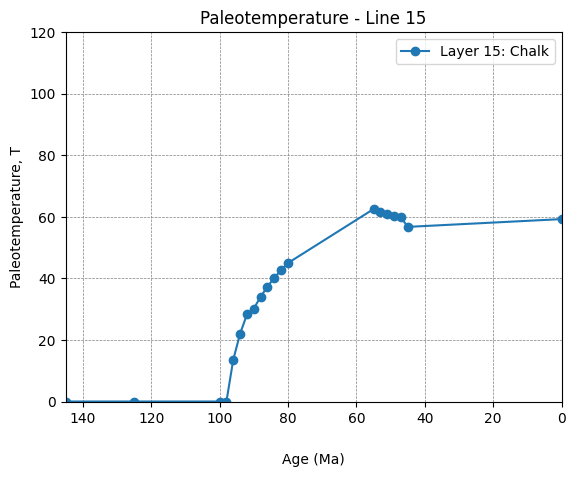

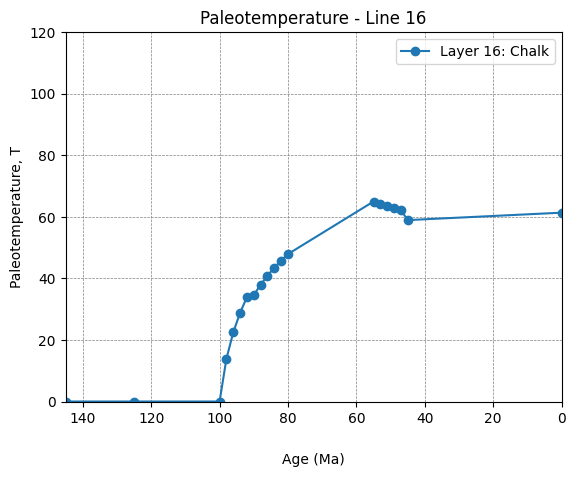

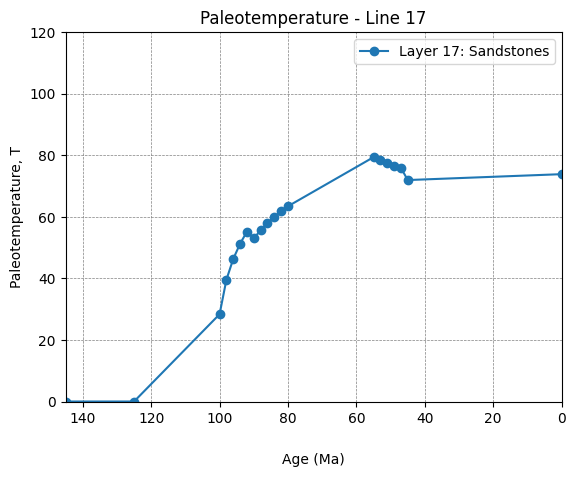

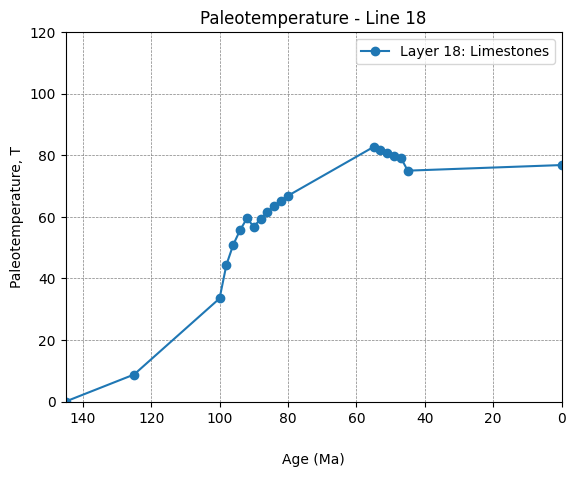

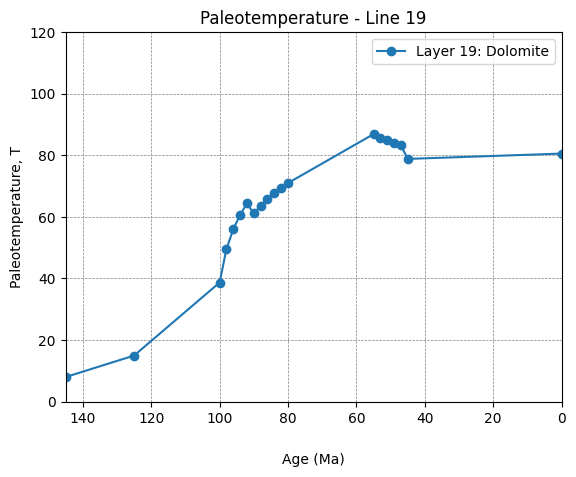

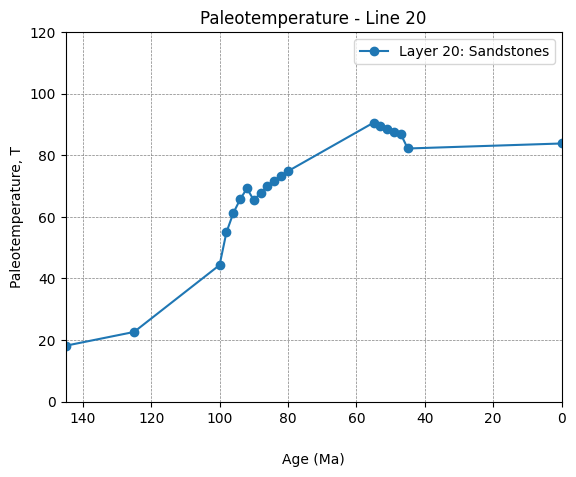

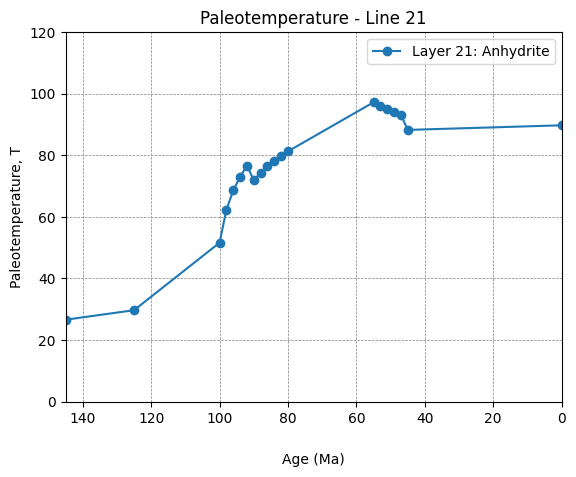

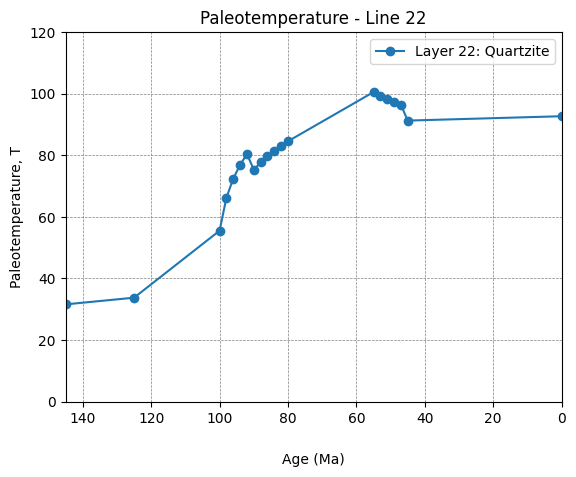

In [ ]:
age_values = [int(age) for age in work_layers['Age (Ma)'][0:]]
# values_for_plot = pd.read_csv('/content/Geotherm_with_A', skiprows=0, header=0)
values_for_plot = pd.read_csv('/content/Geotherm_SG', skiprows=0, header=0)


for row_index, row in values_for_plot.iloc[0:, 3:values_for_plot.shape[1]].iterrows():
    plt.figure()  # Create a new figure for each row
    lithology = values_for_plot["Lithology_type"][row_index]
    plt.plot(age_values, row[::-1], label= "Layer "+ str(row_index) + ": "+ str(lithology), marker='o')
    plt.xlabel('Age (Ma)', labelpad=20)
    plt.ylabel('Paleotemperature, T')
    plt.legend()
    plt.grid(color='gray', linestyle='--', linewidth=0.5)
    plt.xlim(0, 145)
    plt.ylim(0, 120)
    plt.gca().invert_xaxis()
    plt.title(f"Paleotemperature - Line {row_index}")
    plt.show()

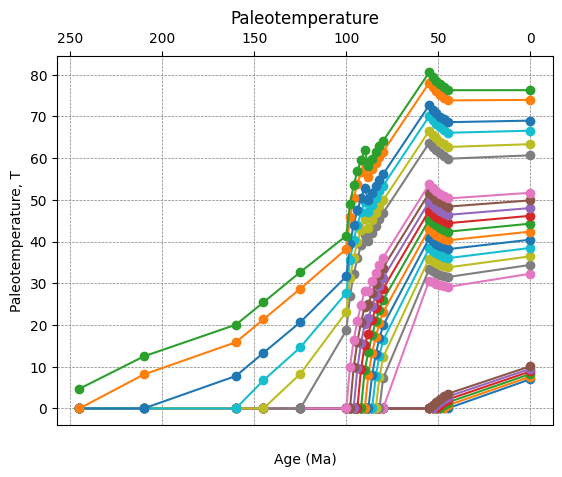

In [ ]:
age_values  = [int(age) for age in work_layers['Age (Ma)'][0:]]
# print(age_values )
# print(age_values[::-1])

values_for_plot = pd.read_csv('/content/Geotherm_with_A',
                              skiprows=0, header=0)


for row_index, row in values_for_plot.iloc[0:, 3:values_for_plot.shape[1]].iterrows():
  plt.plot(age_values, row[::-1], label=str(row_index), marker='o')

# Move the x-axis label to the top
plt.xlabel('Age (Ma)', labelpad=20)
plt.ylabel('Paleotemperature, T')

# Adjust tick parameters
plt.tick_params(axis='x', which='both', bottom=False, top=True, labelbottom=False, labeltop=True)
plt.tick_params(axis='y', which='both', left=True, right=False, labelleft=True, labelright=False)

# plt.legend()
plt.grid(color='gray', linestyle='--', linewidth=0.5)

# plt.xlim(0, 145)
plt.gca().invert_xaxis()
plt.title("Paleotemperature")


# Display the plot
plt.show()

### McKenzie formula

In [ ]:
T_true = pd.DataFrame()
F_true = pd.DataFrame()

age_list = list(df_well['Age (Ma)'][1:])
# age_list = list(df_well['Age (Ma)'][8:11])
print(age_list)

for i, age in enumerate(age_list, start=0):

    work_layers_copy = work_layers.copy()

    T_list, heatflow = [], []

    # Qm = -63*10**-3
    T0 = 0

    print('Age', age)

    # ### расчет corrected_decompaction for Fundament (not in work_layer)
    # if int(age) == age_list[-1]:
    #       T = 0
    #       T_list.append(T)
    #       T_list_constant.append(T)

    sum_variables_1, sum_variables_2 = [], []

### расчет для слоев с заданной литологией (work_layers)
    for row_index, row in enumerate(work_layers_copy[i::].itertuples(), start=i):

      lithology = work_layers_copy.at[row.Index, 'Lithology_type']
      layers_name = work_layers_copy.at[row.Index, 'Event_name']

      A = df_constast.loc[df_constast['Lithology_type'] == str(lithology), 'Radiogenic Heat Production'].iloc[0]

      K = tc_bulk_df.loc[row_index:].loc[tc_bulk_df['Lithology_type'] == str(lithology), f'{age}'].iloc[0]

      work_layers_y = decompaction_df.drop(['Lithology_type'], axis=1, inplace=False)
      y = work_layers_y[f'{age}'].tail(1).iloc[0]

      depth = decompaction_corrected_df.loc[row_index:].loc[decompaction_corrected_df['Lithology_type'] == str(lithology), f'{age}'].iloc[0]

      l = decompaction_df.loc[row_index:].loc[decompaction_df['Lithology_type'] == str(lithology), f'{age}'].iloc[0]


      def temperature(z, t, tc):

        print(z, t, tc)

        # Define the variables and parameters
        beta = 1.7
        a = 125
        # tau = (a**2 * tc)/np.pi**2
        tau = 50
        T1 = 1330
        N = 10  # Number of terms in the sum

        # Define the equation for T/Tm with z as a variable
        T_sum = 0
        for n in range(1, N+1):
            Cn = (-1)**(n+1)/(n) * beta / (n * np.pi) * np.sin(n * np.pi / beta) * np.exp(-n**2 * t / tau) * np.sin(n*np.pi*z/a)
            T_sum += Cn
        T_over_Tm = T0 + (1-z/a + 2/np.pi*T_sum*T1)

        return T_over_Tm

      T_list.append(temperature(depth, age, K))


      def heat_flux(beta, t):

        # Define the variables and parameters
        a = 125
        tau = 62.8
        T1 = 1333
        N = 50  # Number of terms in the sum
        K = 3

        # Define the equation for T/Tm with z as a variable
        T_sum = 0
        for n in range(1, N+1):
            Cn = beta / (n * np.pi) * np.sin(n * np.pi / beta) * np.exp(-n**2 * t / tau)
            T_sum += Cn
        T_over_Tm = K*T1/a * (1 + 2 * T_sum)

        return T_over_Tm

      beta = 1.7
      heatflow.append(heat_flux(beta, age))

      # print(row_index, lithology, layers_name, y, l, K, T_list)


# ### without radio heat
#       if K == 0:
#         sum_variables_3.append(0)
#       else:
#         sum_variables_3.append(l*1000/K)

#       T_no_heat = T0 - Qm*sum(sum_variables_3)
#       T_list_constant.append(T_no_heat)

#       print(row_index, lithology, layers_name, y, l, K)


# ### Save results in table

### with radio heat
    new_col_name = f'{age}'
    ### Save result for decompaction in table
    resized_list_new = np.zeros(work_layers_copy.shape[0])
    resized_list_new[len(resized_list_new) - len(T_list):] = T_list
    new_col_values = resized_list_new
    T_true[new_col_name] = new_col_values

### without radio heat
    resized_list_new = np.zeros(work_layers_copy.shape[0])
    resized_list_new[len(resized_list_new) - len(heatflow):] = heatflow
    new_col_values = resized_list_new
    F_true[new_col_name] = new_col_values

[0, 45, 55, 80, 100, 125, 145, 160, 210, 245, 260]
Age 0
0.4999999999999993 0 0.9723567362696203
0.75 0 2.0339007353427045
1.4999999999999998 0 1.2120273991613346
2.8 0 2.366700025321146
3.7 0 3.3706523489984956
3.9000000000000004 0 3.0355414541771917
4.3 0 5.062992133316692
4.549999999999999 0 3.849875168322586
5.299999999999999 0 6.010585280536438
5.699999999999999 0 6.91736141737204
Age 45
0.5290830462071514 45 1.9285756486360588
1.3291887380071339 45 1.1592201565488158
2.659257053491877 45 2.295179662645682
3.5666660576986455 45 3.3187801310059903
3.7673096278662666 45 3.0200565841236457
4.167828392805276 45 5.051974246458476
4.419135740953499 45 3.8159071788813987
5.1694374379485915 45 6.010585280536438
5.569961569430558 45 6.899730500188495
Age 55
1.1659014066130473 55 1.086251706683918
2.5394442416637926 55 2.1994172139463712
3.4562127720134876 55 3.2604743641269454
3.6576874103314116 55 2.9995328962850074
4.0588725942623265 55 5.040980336297759
4.311812426767575 55 3.7655163130

In [ ]:
T_true

,0,45,55,80,100,125,145,160,210,245,260
0,6.055821,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
1,8.584900,3.421555,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
2,16.182348,7.082546,5.331649,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
3,29.416517,13.161950,10.429528,5.249944,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
4,38.652564,17.301697,13.826032,7.387475,2.923847,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
5,40.715276,18.215939,14.571591,7.844969,3.270209,1.197912,0.000000,0.000000,0.000000,0.000000,0.0
6,44.853088,20.039515,16.055093,8.744778,3.901248,1.611386,1.331838,0.000000,0.000000,0.000000,0.0
7,47.448014,21.182700,16.989612,9.323071,4.338409,1.916990,1.546011,1.191028,0.000000,0.000000,0.0
8,55.276061,24.590548,19.758989,10.993774,5.466777,2.604712,2.005959,1.531551,1.125010,0.000000,0.0
9,59.478903,26.406177,21.236242,11.889532,6.085128,2.991105,2.266419,1.727254,1.196121,1.035079,0.0


In [ ]:
F_true

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,0,45,55,80,100,125,145,160,210,245,260
0,54.13014,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
1,54.13014,47.726653,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
2,54.13014,47.726653,45.585922,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
3,54.13014,47.726653,45.585922,41.25202,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
4,54.13014,47.726653,45.585922,41.25202,38.751473,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
5,54.13014,47.726653,45.585922,41.25202,38.751473,36.538988,0.000000,0.000000,0.000000,0.000000,0.0
6,54.13014,47.726653,45.585922,41.25202,38.751473,36.538988,35.300264,0.000000,0.000000,0.000000,0.0
7,54.13014,47.726653,45.585922,41.25202,38.751473,36.538988,35.300264,34.597716,0.000000,0.000000,0.0
8,54.13014,47.726653,45.585922,41.25202,38.751473,36.538988,35.300264,34.597716,33.167447,0.000000,0.0
9,54.13014,47.726653,45.585922,41.25202,38.751473,36.538988,35.300264,34.597716,33.167447,32.665231,0.0


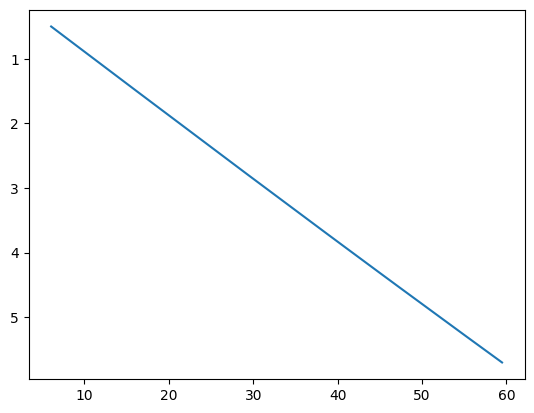

In [ ]:
plt.plot(T_true['0'], decompaction_corrected_df['0'], label='McKenzie')
plt.gca().invert_yaxis()